## Import

In [1]:
# importing the libraries
import os
import pandas as pd
import numpy as np
from itertools import chain

# for reading and displaying images
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# models
from src.architectures.model_util import load_model, save_checkpoint

# other files
from src.run import *
from src.data_util import *

# Torch
from torch.optim import *
import torch.optim as optim
from torchsummary import summary
from tensorboardX import SummaryWriter

# DeepNotion
from DeepNotion.build import *

# CAM - M3dCam
from medcam import medcam

## Load Configurations

In [2]:
from src.config import *
cfg = load_config()

## Debug

In [3]:
# unindent if needed
# train_dset = MyDataset()
# test_dset = MyDataset(test=True)

# train_loader = DataLoader(train_dset, batch_size=8)
# test_loader = DataLoader(test_dset, batch_size=8)

## Tracking on Notion

In [4]:
print(today())
root, client = login('./config.yml')
page = make_page(root)

2021.01.30.13:57


In [5]:
toggle = page.children.add_new(ToggleBlock, title='Configuration')

for name, value in cfg.get_dict().items():
    if name not in ['npy_path', 'token_v2', 'url', 'schema', 'test_schema', 'task_type', 'fold']:
        txt = '**' + name + '** ' + str(value)
        toggle.children.add_new(BulletedListBlock, title=txt)

In [6]:
# fold_db = make_db(page, schema=cfg.schema)
# test_db = make_db(page, schema=cfg.test_schema)

## Train

### No Fold

In [7]:
model, cfg.device = load_model(cfg.model_name, verbose=False)
optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)

trn_dp, aug_dp, tst_dp = DataPacket(), DataPacket(), DataPacket()
aug_dp.delete('corr')

Model Resnet is selected.


In [ ]:
best_mae = cfg.best_mae
fold = None
db = make_db(page, schema=cfg.schema, title='Results')
for e in range(cfg.epochs):
    
    start_time = time.time()
    print(f'Epoch {e+1} / {cfg.epochs}, BEST MAE {best_mae:.3f}')
    cfg.test = False
    model, trn_dp, trn_res = train(model, optimizer, fn_lst, trn_dp, cfg, fold=fold)
    model, aug_dp, aug_res = train(model, optimizer, fn_lst, aug_dp, cfg, fold=fold, augment=True)
    cfg.test = True
    model, tst_dp, tst_res = eval(model, fn_lst, tst_dp, cfg, fold=fold)
    elapsed_time = round(time.time() - start_time, 3)
       
    if best_mae > tst_dp.mae[-1]:
        
        best_mae = tst_dp.mae[-1]
        model_name = f'{cfg.model_name}_ep{e}-{cfg.epochs}_sd{cfg.seed}_mae{best_mae:.3f}.pt'
        save_checkpoint(cfg.get_dict(), model_name, is_best=True)
        
    df = pd.concat([make_df(trn_res, 'Train'),
                    make_df(aug_res, 'Aug'),
                    make_df(tst_res, 'Test')], ignore_index=True)
    
    trn_dp.corr.update(df[df['Label'] == 'Train'].corr().Prediction['True'])
    trn_dp.refresh()
    tst_dp.corr.update(df[df['Label'] == 'Test'].corr().Prediction['True'])
    tst_dp.refresh()

    if e % 1 == 0:
        trn_dp.info('train')
        aug_dp.info('augme')
        tst_dp.info('test ')
        
        data = gather_data(e=e,
                   train=trn_dp, valid=tst_dp, aug=aug_dp,
                   time=elapsed_time, cfg=cfg)
        
        print(data)
        write_db(db, data)
        

    if (e+1) % 5 == 0:
        plt.title(f"L1 Losses among epochs, {e}th")
        plt.plot(list(trn_dp.loss), label='Train')
        plt.plot(list(tst_dp.loss), label='Test')
        plt.grid(); plt.legend()

        sns.lmplot(data=df, x='True', y='Prediction', hue='Label')
        plt.grid()
        plt.show()
        

    torch.cuda.empty_cache()

Epoch 1 / 100, BEST MAE 10.000
[train] 37.3 sec [train] 329.1 sec [eval] 12.0 sec 
[TRAIN]:: Loss=3510.406 Mae=56.928 Rmse=59.191 Corr=0.422 
[AUGME]:: Loss=3410.334 Mae=56.225 Rmse=58.337 
[TEST ]:: Loss=3335.910 Mae=55.673 Rmse=57.653 Corr=0.633 
{'Epoch/Config': '0', 'Train MAE': 56.92795129255815, 'Train LOSS': 3510.4063332297587, 'Train RMSE': 59.19068579240279, 'Train CORR': 0.42236766801089454, 'Valid MAE': 55.67290912974965, 'Valid LOSS': 3335.9096457741475, 'Valid RMSE': 57.65321904962713, 'Valid CORR': 0.6332562667002963, 'Aug MAE': 56.225289431485265, 'Aug LOSS': 3410.333729137074, 'Aug RMSE': 58.33743112737482, 'Elapsed Time': 378.413, 'Learning Rate': 0.0001}


### kFold

In [3]:
models = []
packets = []
tst_dp = DataPacket()

#### Single Run (for error...)

Fold 4 / 5
Model Resnet is selected.
Epoch 1 / 100, BEST MAE 10.000
[train] 55.1 sec [train] 357.7 sec [eval] 12.8 sec  [TRAIN]:: Loss=3492.933 Mae=56.742 Rmse=59.042 Corr=0.347 
[AUGME]:: Loss=3408.597 Mae=56.115 Rmse=58.323 
[VALID]:: Loss=3302.651 Mae=55.327 Rmse=57.362 Corr=0.637 
Epoch 2 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 389.2 sec [eval] 12.3 sec  [TRAIN]:: Loss=3348.126 Mae=55.660 Rmse=57.801 Corr=0.693 
[AUGME]:: Loss=3301.796 Mae=55.285 Rmse=57.399 
[VALID]:: Loss=3136.586 Mae=53.656 Rmse=55.892 Corr=0.151 
Epoch 3 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 330.4 sec [eval] 12.5 sec  [TRAIN]:: Loss=3253.611 Mae=54.876 Rmse=56.977 Corr=0.740 
[AUGME]:: Loss=3210.851 Mae=54.503 Rmse=56.601 
[VALID]:: Loss=3226.443 Mae=54.778 Rmse=56.702 Corr=0.688 
Epoch 4 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 368.1 sec [eval] 12.5 sec  [TRAIN]:: Loss=3162.913 Mae=54.087 Rmse=56.175 Corr=0.756 
[AUGME]:: Loss=3118.562 Mae=53.697 Rmse=55.779 
[VALID]:: Loss=3091.035 Ma

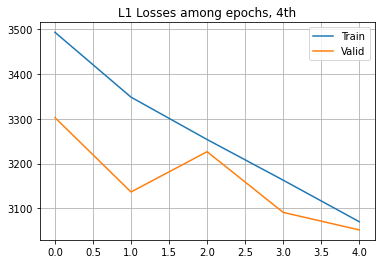

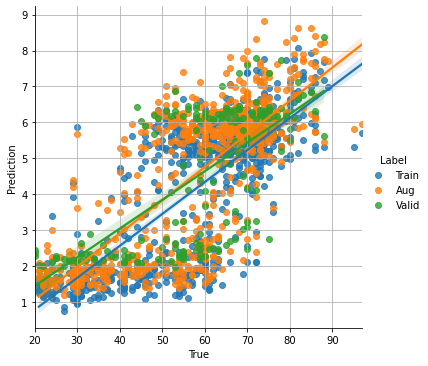

Epoch 6 / 100, BEST MAE 10.000
[train] 50.8 sec [train] 341.0 sec [eval] 13.1 sec  [TRAIN]:: Loss=2976.115 Mae=52.425 Rmse=54.487 Corr=0.769 
[AUGME]:: Loss=2929.150 Mae=51.994 Rmse=54.054 
[VALID]:: Loss=3020.036 Mae=52.711 Rmse=54.845 Corr=0.374 
Epoch 7 / 100, BEST MAE 10.000
[train] 53.1 sec [train] 370.2 sec [eval] 13.0 sec  [TRAIN]:: Loss=2877.920 Mae=51.534 Rmse=53.578 Corr=0.772 
[AUGME]:: Loss=2830.440 Mae=51.092 Rmse=53.133 
[VALID]:: Loss=2882.321 Mae=51.585 Rmse=53.587 Corr=0.592 
Epoch 8 / 100, BEST MAE 10.000
[train] 50.8 sec [train] 358.3 sec [eval] 12.8 sec  [TRAIN]:: Loss=2776.914 Mae=50.613 Rmse=52.627 Corr=0.786 
[AUGME]:: Loss=2726.695 Mae=50.140 Rmse=52.148 
[VALID]:: Loss=2791.531 Mae=50.612 Rmse=52.731 Corr=0.457 
Epoch 9 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 384.9 sec [eval] 13.2 sec  [TRAIN]:: Loss=2673.553 Mae=49.655 Rmse=51.635 Corr=0.798 
[AUGME]:: Loss=2623.684 Mae=49.169 Rmse=51.150 
[VALID]:: Loss=2677.187 Mae=49.589 Rmse=51.640 Corr=0.562 
Epoc

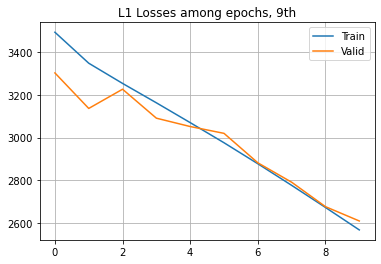

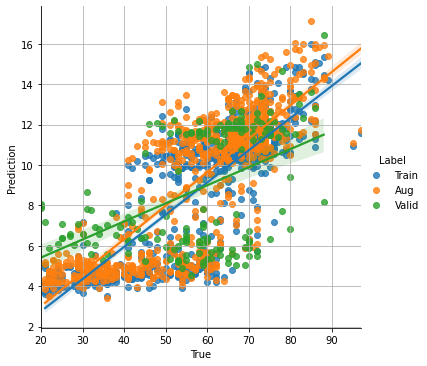

Epoch 11 / 100, BEST MAE 10.000
[train] 52.3 sec [train] 374.7 sec [eval] 12.0 sec  [TRAIN]:: Loss=2459.674 Mae=47.641 Rmse=49.520 Corr=0.833 
[AUGME]:: Loss=2406.480 Mae=47.094 Rmse=48.980 
[VALID]:: Loss=2474.855 Mae=47.668 Rmse=49.654 Corr=0.628 
Epoch 12 / 100, BEST MAE 10.000
[train] 49.9 sec [train] 311.0 sec [eval] 12.1 sec  [TRAIN]:: Loss=2345.440 Mae=46.549 Rmse=48.353 Corr=0.852 
[AUGME]:: Loss=2293.063 Mae=45.979 Rmse=47.808 
[VALID]:: Loss=2419.565 Mae=46.972 Rmse=49.086 Corr=0.493 
Epoch 13 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 324.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=2229.577 Mae=45.421 Rmse=47.139 Corr=0.876 
[AUGME]:: Loss=2179.095 Mae=44.842 Rmse=46.600 
[VALID]:: Loss=2348.241 Mae=45.978 Rmse=48.348 Corr=0.328 
Epoch 14 / 100, BEST MAE 10.000
[train] 49.1 sec [train] 361.5 sec [eval] 12.1 sec  [TRAIN]:: Loss=2112.304 Mae=44.246 Rmse=45.878 Corr=0.892 
[AUGME]:: Loss=2063.099 Mae=43.635 Rmse=45.339 
[VALID]:: Loss=2215.471 Mae=44.927 Rmse=46.970 Corr=0.602 


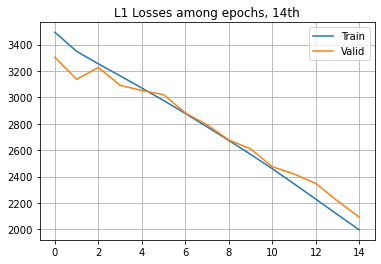

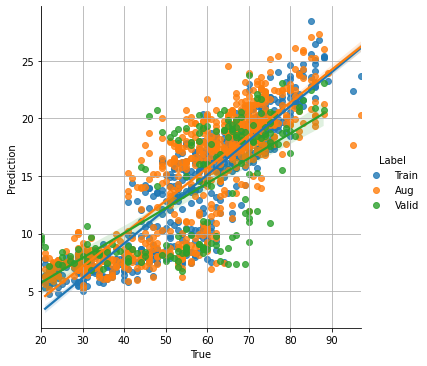

Epoch 16 / 100, BEST MAE 10.000
[train] 49.3 sec [train] 355.0 sec [eval] 12.1 sec  [TRAIN]:: Loss=1884.223 Mae=41.864 Rmse=43.320 Corr=0.917 
[AUGME]:: Loss=1834.584 Mae=41.165 Rmse=42.743 
[VALID]:: Loss=1719.834 Mae=39.062 Rmse=41.353 Corr=0.714 
Epoch 17 / 100, BEST MAE 10.000
[train] 49.0 sec [train] 336.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=1766.403 Mae=40.576 Rmse=41.938 Corr=0.927 
[AUGME]:: Loss=1720.755 Mae=39.859 Rmse=41.389 
[VALID]:: Loss=1883.502 Mae=41.302 Rmse=43.305 Corr=0.625 
Epoch 18 / 100, BEST MAE 10.000
[train] 49.0 sec [train] 352.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=1651.429 Mae=39.241 Rmse=40.543 Corr=0.933 
[AUGME]:: Loss=1614.535 Mae=38.569 Rmse=40.085 
[VALID]:: Loss=1678.416 Mae=39.101 Rmse=40.883 Corr=0.787 
Epoch 19 / 100, BEST MAE 10.000
[train] 49.4 sec [train] 329.6 sec [eval] 12.3 sec  [TRAIN]:: Loss=1540.462 Mae=37.944 Rmse=39.150 Corr=0.942 
[AUGME]:: Loss=1499.957 Mae=37.223 Rmse=38.631 
[VALID]:: Loss=1628.549 Mae=38.504 Rmse=40.263 Corr=0.741 


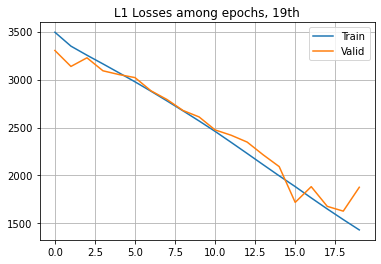

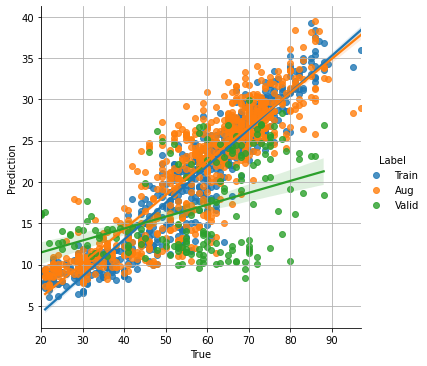

Epoch 21 / 100, BEST MAE 10.000
[train] 49.1 sec [train] 352.7 sec [eval] 12.2 sec  [TRAIN]:: Loss=1330.587 Mae=35.308 Rmse=36.371 Corr=0.953 
[AUGME]:: Loss=1297.377 Mae=34.596 Rmse=35.910 
[VALID]:: Loss=1277.180 Mae=33.517 Rmse=35.624 Corr=0.771 
Epoch 22 / 100, BEST MAE 10.000
[train] 48.9 sec [train] 321.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=1231.991 Mae=33.979 Rmse=34.989 Corr=0.954 
[AUGME]:: Loss=1204.693 Mae=33.309 Rmse=34.596 
[VALID]:: Loss=1254.968 Mae=33.660 Rmse=35.332 Corr=0.805 
Epoch 23 / 100, BEST MAE 10.000
[train] 48.9 sec [train] 332.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=1138.483 Mae=32.698 Rmse=33.626 Corr=0.959 
[AUGME]:: Loss=1110.355 Mae=31.974 Rmse=33.205 
[VALID]:: Loss=976.620 Mae=29.234 Rmse=31.140 Corr=0.824 
Epoch 24 / 100, BEST MAE 10.000
[train] 49.1 sec [train] 326.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=1045.852 Mae=31.333 Rmse=32.218 Corr=0.962 
[AUGME]:: Loss=1023.946 Mae=30.646 Rmse=31.875 
[VALID]:: Loss=874.039 Mae=27.549 Rmse=29.461 Corr=0.813 
Ep

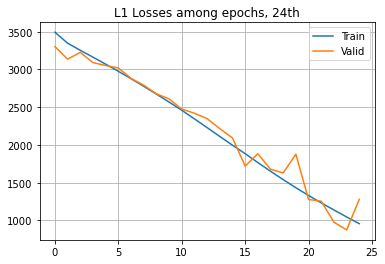

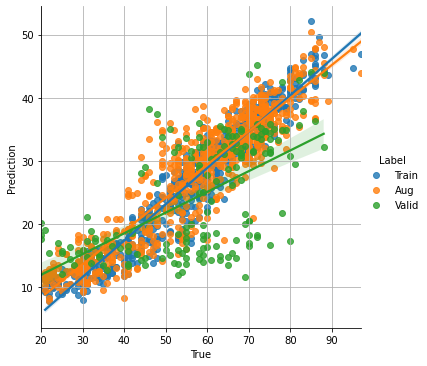

Epoch 26 / 100, BEST MAE 10.000
[train] 49.0 sec [train] 351.7 sec [eval] 12.3 sec  [TRAIN]:: Loss=875.357 Mae=28.682 Rmse=29.452 Corr=0.963 
[AUGME]:: Loss=856.118 Mae=27.996 Rmse=29.125 
[VALID]:: Loss=853.073 Mae=27.322 Rmse=29.111 Corr=0.801 
Epoch 27 / 100, BEST MAE 10.000
[train] 49.4 sec [train] 355.4 sec [eval] 12.3 sec  [TRAIN]:: Loss=794.229 Mae=27.301 Rmse=28.040 Corr=0.964 
[AUGME]:: Loss=779.507 Mae=26.675 Rmse=27.782 
[VALID]:: Loss=1128.953 Mae=31.120 Rmse=33.489 Corr=0.617 
Epoch 28 / 100, BEST MAE 10.000
[train] 49.0 sec [train] 338.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=724.633 Mae=26.064 Rmse=26.773 Corr=0.965 
[AUGME]:: Loss=708.919 Mae=25.394 Rmse=26.472 
[VALID]:: Loss=840.719 Mae=26.871 Rmse=28.889 Corr=0.795 
Epoch 29 / 100, BEST MAE 10.000
[train] 49.1 sec [train] 339.7 sec [eval] 12.2 sec  [TRAIN]:: Loss=657.585 Mae=24.819 Rmse=25.490 Corr=0.967 
[AUGME]:: Loss=641.472 Mae=24.112 Rmse=25.173 
[VALID]:: Loss=603.734 Mae=22.515 Rmse=24.469 Corr=0.824 
Epoch 30 / 

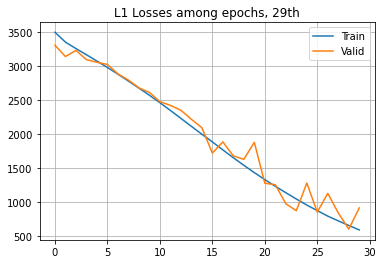

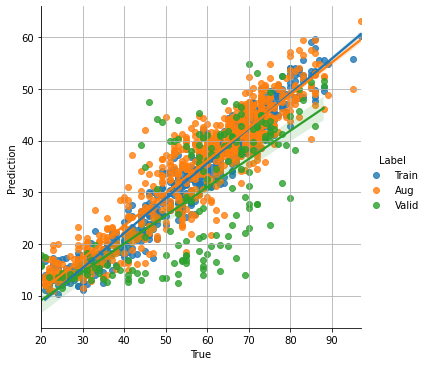

Epoch 31 / 100, BEST MAE 10.000
[train] 49.2 sec [train] 345.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=530.163 Mae=22.296 Rmse=22.850 Corr=0.974 
[AUGME]:: Loss=521.250 Mae=21.628 Rmse=22.665 
[VALID]:: Loss=421.974 Mae=18.186 Rmse=20.441 Corr=0.789 
Epoch 32 / 100, BEST MAE 10.000
[train] 49.1 sec [train] 369.6 sec [eval] 12.1 sec  [TRAIN]:: Loss=471.642 Mae=21.019 Rmse=21.531 Corr=0.975 
[AUGME]:: Loss=467.836 Mae=20.389 Rmse=21.447 
[VALID]:: Loss=707.218 Mae=24.176 Rmse=26.506 Corr=0.703 
Epoch 33 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 327.4 sec [eval] 12.2 sec  [TRAIN]:: Loss=421.732 Mae=19.851 Rmse=20.338 Corr=0.975 
[AUGME]:: Loss=419.249 Mae=19.242 Rmse=20.282 
[VALID]:: Loss=343.264 Mae=15.894 Rmse=18.383 Corr=0.739 
Epoch 34 / 100, BEST MAE 10.000
[train] 49.4 sec [train] 332.3 sec [eval] 12.3 sec  [TRAIN]:: Loss=372.286 Mae=18.626 Rmse=19.084 Corr=0.974 
[AUGME]:: Loss=373.917 Mae=18.020 Rmse=19.132 
[VALID]:: Loss=264.574 Mae=13.905 Rmse=16.155 Corr=0.784 
Epoch 35 / 1

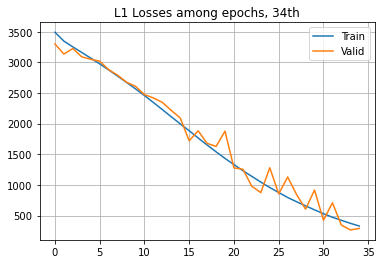

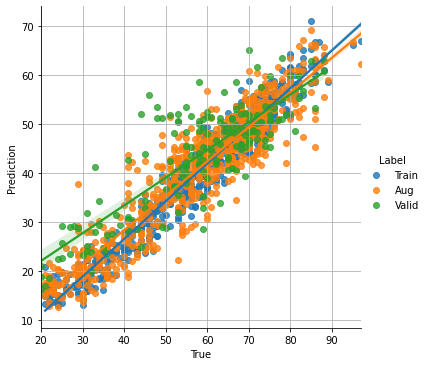

Epoch 36 / 100, BEST MAE 10.000
[train] 49.4 sec [train] 330.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=286.581 Mae=16.280 Rmse=16.690 Corr=0.975 
[AUGME]:: Loss=292.309 Mae=15.752 Rmse=16.865 
[VALID]:: Loss=292.606 Mae=15.117 Rmse=17.010 Corr=0.844 
Epoch 37 / 100, BEST MAE 10.000
[train] 49.2 sec [train] 308.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=249.819 Mae=15.175 Rmse=15.548 Corr=0.977 
[AUGME]:: Loss=254.811 Mae=14.630 Rmse=15.723 
[VALID]:: Loss=213.849 Mae=12.390 Rmse=14.505 Corr=0.624 
Epoch 38 / 100, BEST MAE 10.000
[train] 49.3 sec [train] 330.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=218.985 Mae=14.145 Rmse=14.522 Corr=0.976 
[AUGME]:: Loss=226.607 Mae=13.676 Rmse=14.813 
[VALID]:: Loss=182.336 Mae=11.211 Rmse=13.396 Corr=0.815 
Epoch 39 / 100, BEST MAE 10.000
[train] 49.3 sec [train] 329.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=186.696 Mae=13.009 Rmse=13.365 Corr=0.976 
[AUGME]:: Loss=192.557 Mae=12.558 Rmse=13.609 
[VALID]:: Loss=195.258 Mae=12.063 Rmse=13.877 Corr=0.692 
Epoch 40 / 1

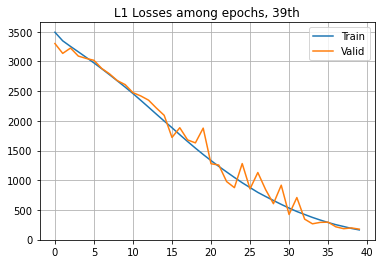

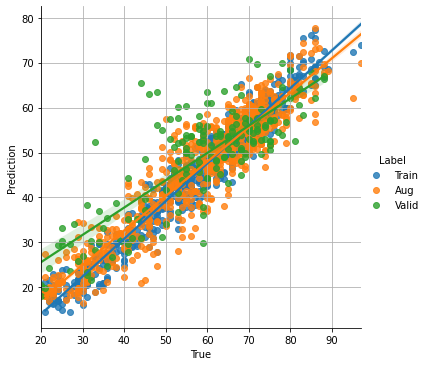

Epoch 41 / 100, BEST MAE 10.000
[train] 49.0 sec [train] 346.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=137.284 Mae=11.044 Rmse=11.367 Corr=0.978 
[AUGME]:: Loss=148.451 Mae=10.809 Rmse=11.912 
[VALID]:: Loss=194.381 Mae=11.960 Rmse=13.859 Corr=0.812 
Epoch 42 / 100, BEST MAE 10.000
[train] 49.1 sec [train] 327.4 sec [eval] 12.1 sec  Saving ...


OSError: [WinError 433] A device which does not exist was specified: './models/'

In [5]:
fold = 3
print(f'Fold {fold+1} / {cfg.folds}')
model, dps, res = run(cfg, fold)
models.append(model)
packets.append(dps)

cfg.test = True
model, tst_dp, tst_res = eval(model, fn_lst, tst_dp, cfg, fold=None)

df = pd.concat([make_df(res[0], 'Train'),
               make_df(res[1], 'Valid'),
               make_df(tst_res, 'Test')], ignore_index=True)

tst_dp.corr.update(df[df['Label'] == 'Test'].corr().Prediction['True'])
tst_dp.refresh()

# Show Holdout testset information
tst_dp.info('Holdout test')
sns.lmplot(data=df, x='True', y='Prediction', hue='Label')
plt.grid()
plt.show()

torch.cuda.empty_cache()

#### Whole Run

Fold 1 / 5
Model Resnet is selected.
Epoch 1 / 100, BEST MAE 10.000
[train] 51.7 sec [train] 329.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=3549.464 Mae=57.290 Rmse=59.519 Corr=0.448 
[AUGME]:: Loss=3456.019 Mae=56.635 Rmse=58.727 
[VALID]:: Loss=3337.477 Mae=55.644 Rmse=57.668 Corr=0.580 
Epoch 2 / 100, BEST MAE 10.000
[train] 50.0 sec [train] 321.6 sec [eval] 12.1 sec  [TRAIN]:: Loss=3396.380 Mae=56.145 Rmse=58.217 Corr=0.719 
[AUGME]:: Loss=3352.477 Mae=55.765 Rmse=57.838 
[VALID]:: Loss=3293.943 Mae=55.350 Rmse=57.293 Corr=0.706 
Epoch 3 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 322.7 sec [eval] 12.1 sec  [TRAIN]:: Loss=3306.551 Mae=55.372 Rmse=57.440 Corr=0.751 
[AUGME]:: Loss=3263.744 Mae=55.001 Rmse=57.066 
[VALID]:: Loss=3158.660 Mae=54.048 Rmse=56.099 Corr=0.645 
Epoch 4 / 100, BEST MAE 10.000
[train] 50.2 sec [train] 317.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=3219.399 Mae=54.610 Rmse=56.676 Corr=0.764 
[AUGME]:: Loss=3176.145 Mae=54.223 Rmse=56.293 
[VALID]:: Loss=3226.112 Ma

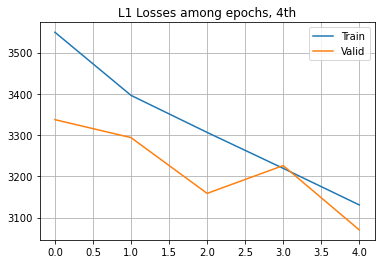

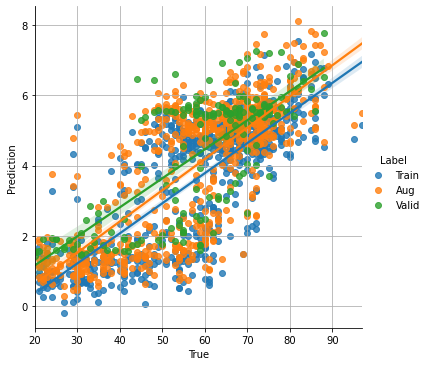

Epoch 6 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 344.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=3040.169 Mae=53.010 Rmse=55.072 Corr=0.779 
[AUGME]:: Loss=2996.855 Mae=52.609 Rmse=54.677 
[VALID]:: Loss=3057.583 Mae=53.173 Rmse=55.191 Corr=0.567 
Epoch 7 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 368.8 sec [eval] 12.1 sec  [TRAIN]:: Loss=2948.518 Mae=52.172 Rmse=54.233 Corr=0.780 
[AUGME]:: Loss=2905.174 Mae=51.771 Rmse=53.832 
[VALID]:: Loss=2956.939 Mae=52.232 Rmse=54.271 Corr=0.548 
Epoch 8 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 382.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=2856.136 Mae=51.324 Rmse=53.374 Corr=0.784 
[AUGME]:: Loss=2809.274 Mae=50.873 Rmse=52.933 
[VALID]:: Loss=2924.071 Mae=51.780 Rmse=53.963 Corr=0.348 
Epoch 9 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 388.4 sec [eval] 12.1 sec  [TRAIN]:: Loss=2754.609 Mae=50.385 Rmse=52.414 Corr=0.794 
[AUGME]:: Loss=2705.402 Mae=49.920 Rmse=51.943 
[VALID]:: Loss=2793.384 Mae=50.610 Rmse=52.744 Corr=0.451 
Epoc

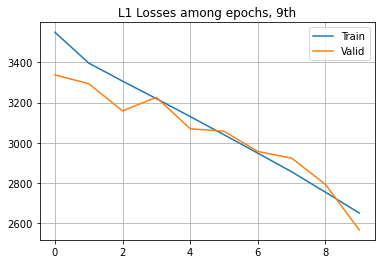

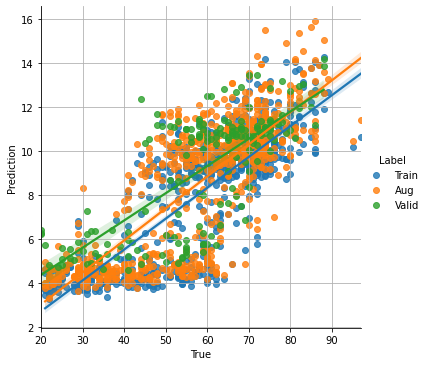

Epoch 11 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 375.2 sec [eval] 12.2 sec  [TRAIN]:: Loss=2539.219 Mae=48.373 Rmse=50.317 Corr=0.828 
[AUGME]:: Loss=2485.078 Mae=47.835 Rmse=49.776 
[VALID]:: Loss=2512.380 Mae=47.971 Rmse=50.021 Corr=0.582 
Epoch 12 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 377.8 sec [eval] 12.3 sec  [TRAIN]:: Loss=2421.822 Mae=47.263 Rmse=49.137 Corr=0.847 
[AUGME]:: Loss=2365.626 Mae=46.689 Rmse=48.562 
[VALID]:: Loss=2369.584 Mae=46.712 Rmse=48.589 Corr=0.705 
Epoch 13 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 367.5 sec [eval] 12.3 sec  [TRAIN]:: Loss=2299.006 Mae=46.087 Rmse=47.870 Corr=0.865 
[AUGME]:: Loss=2240.836 Mae=45.462 Rmse=47.259 
[VALID]:: Loss=2325.370 Mae=46.189 Rmse=48.128 Corr=0.679 
Epoch 14 / 100, BEST MAE 10.000
[train] 50.7 sec [train] 372.7 sec [eval] 12.2 sec  [TRAIN]:: Loss=2172.828 Mae=44.844 Rmse=46.533 Corr=0.884 
[AUGME]:: Loss=2120.210 Mae=44.228 Rmse=45.964 
[VALID]:: Loss=2274.306 Mae=45.434 Rmse=47.591 Corr=0.490 


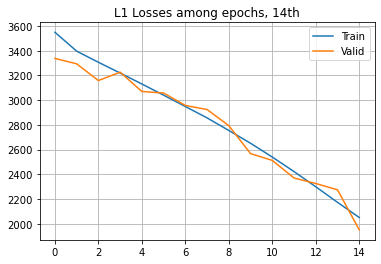

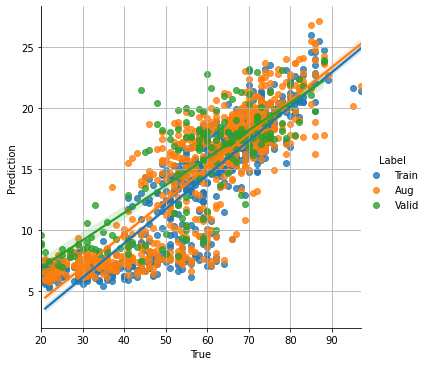

Epoch 16 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 378.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=1926.883 Mae=42.301 Rmse=43.810 Corr=0.910 
[AUGME]:: Loss=1880.645 Mae=41.663 Rmse=43.279 
[VALID]:: Loss=1915.042 Mae=41.861 Rmse=43.672 Corr=0.819 
Epoch 17 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 359.4 sec [eval] 12.2 sec  [TRAIN]:: Loss=1806.837 Mae=40.993 Rmse=42.418 Corr=0.922 
[AUGME]:: Loss=1762.653 Mae=40.335 Rmse=41.893 
[VALID]:: Loss=1894.360 Mae=41.556 Rmse=43.441 Corr=0.674 
Epoch 18 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 355.6 sec [eval] 12.1 sec  [TRAIN]:: Loss=1689.615 Mae=39.665 Rmse=41.012 Corr=0.930 
[AUGME]:: Loss=1648.411 Mae=39.003 Rmse=40.507 
[VALID]:: Loss=1516.494 Mae=36.728 Rmse=38.842 Corr=0.751 
Epoch 19 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 374.1 sec [eval] 12.1 sec  [TRAIN]:: Loss=1576.052 Mae=38.352 Rmse=39.603 Corr=0.939 
[AUGME]:: Loss=1536.554 Mae=37.684 Rmse=39.101 
[VALID]:: Loss=1801.819 Mae=40.351 Rmse=42.364 Corr=0.611 


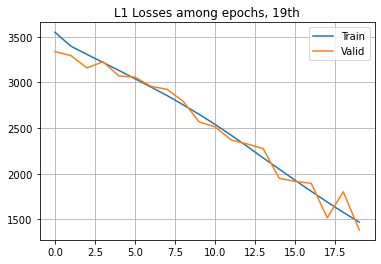

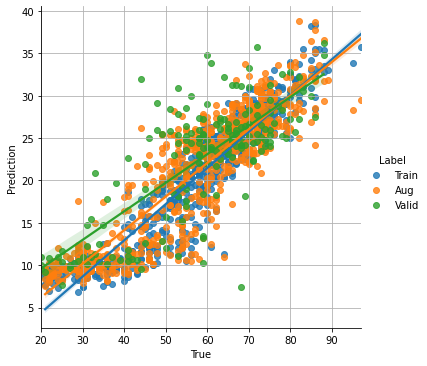

Epoch 21 / 100, BEST MAE 10.000
[train] 50.0 sec [train] 362.0 sec [eval] 12.1 sec  [TRAIN]:: Loss=1359.689 Mae=35.631 Rmse=36.768 Corr=0.943 
[AUGME]:: Loss=1329.653 Mae=34.999 Rmse=36.356 
[VALID]:: Loss=1171.587 Mae=31.919 Rmse=34.121 Corr=0.759 
Epoch 22 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 361.6 sec [eval] 12.1 sec  [TRAIN]:: Loss=1261.802 Mae=34.307 Rmse=35.411 Corr=0.942 
[AUGME]:: Loss=1226.875 Mae=33.634 Rmse=34.913 
[VALID]:: Loss=1070.848 Mae=30.796 Rmse=32.646 Corr=0.800 
Epoch 23 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 321.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=1165.806 Mae=33.029 Rmse=34.027 Corr=0.952 
[AUGME]:: Loss=1136.120 Mae=32.368 Rmse=33.588 
[VALID]:: Loss=867.802 Mae=26.358 Rmse=29.354 Corr=0.613 
Epoch 24 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 381.3 sec [eval] 12.1 sec  [TRAIN]:: Loss=1075.665 Mae=31.746 Rmse=32.676 Corr=0.955 
[AUGME]:: Loss=1048.515 Mae=31.055 Rmse=32.261 
[VALID]:: Loss=980.227 Mae=29.424 Rmse=31.227 Corr=0.817 
Ep

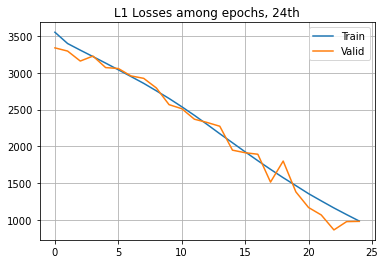

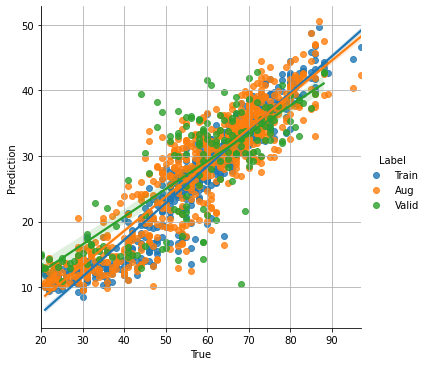

Epoch 26 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 370.2 sec [eval] 12.1 sec  [TRAIN]:: Loss=902.257 Mae=29.062 Rmse=29.904 Corr=0.957 
[AUGME]:: Loss=883.149 Mae=28.468 Rmse=29.587 
[VALID]:: Loss=755.016 Mae=25.309 Rmse=27.384 Corr=0.830 
Epoch 27 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 360.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=827.149 Mae=27.842 Rmse=28.622 Corr=0.960 
[AUGME]:: Loss=809.655 Mae=27.167 Rmse=28.311 
[VALID]:: Loss=539.234 Mae=20.619 Rmse=23.130 Corr=0.803 
Epoch 28 / 100, BEST MAE 10.000
[train] 50.3 sec [train] 357.5 sec [eval] 12.3 sec  [TRAIN]:: Loss=752.695 Mae=26.533 Rmse=27.293 Corr=0.960 
[AUGME]:: Loss=735.346 Mae=25.857 Rmse=26.975 
[VALID]:: Loss=1225.607 Mae=32.375 Rmse=34.903 Corr=0.561 
Epoch 29 / 100, BEST MAE 10.000
[train] 50.0 sec [train] 353.4 sec [eval] 12.1 sec  [TRAIN]:: Loss=681.909 Mae=25.286 Rmse=25.959 Corr=0.967 
[AUGME]:: Loss=667.149 Mae=24.647 Rmse=25.675 
[VALID]:: Loss=423.335 Mae=17.660 Rmse=20.487 Corr=0.602 
Epoch 30 / 

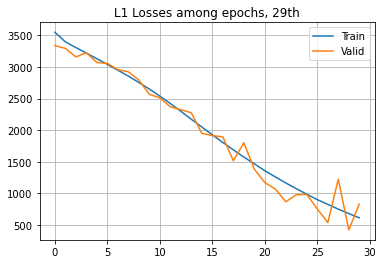

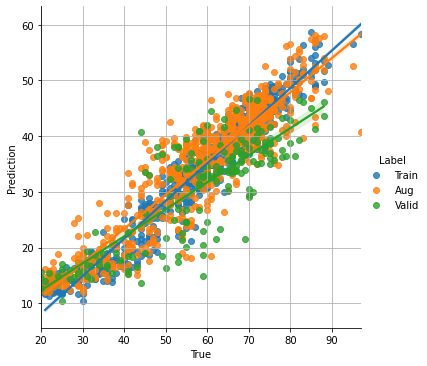

Epoch 31 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 350.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=553.317 Mae=22.789 Rmse=23.351 Corr=0.971 
[AUGME]:: Loss=544.797 Mae=22.147 Rmse=23.166 
[VALID]:: Loss=430.995 Mae=18.047 Rmse=20.667 Corr=0.795 
Epoch 32 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 395.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=497.707 Mae=21.609 Rmse=22.129 Corr=0.974 
[AUGME]:: Loss=490.198 Mae=20.881 Rmse=21.954 
[VALID]:: Loss=343.120 Mae=15.877 Rmse=18.430 Corr=0.806 
Epoch 33 / 100, BEST MAE 10.000
[train] 49.4 sec [train] 383.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=443.456 Mae=20.275 Rmse=20.869 Corr=0.966 
[AUGME]:: Loss=435.886 Mae=19.624 Rmse=20.692 
[VALID]:: Loss=323.280 Mae=15.159 Rmse=17.902 Corr=0.748 
Epoch 34 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 362.5 sec [eval] 12.3 sec  [TRAIN]:: Loss=390.169 Mae=19.075 Rmse=19.552 Corr=0.974 
[AUGME]:: Loss=386.226 Mae=18.411 Rmse=19.448 
[VALID]:: Loss=699.569 Mae=23.819 Rmse=26.345 Corr=0.670 
Epoch 35 / 1

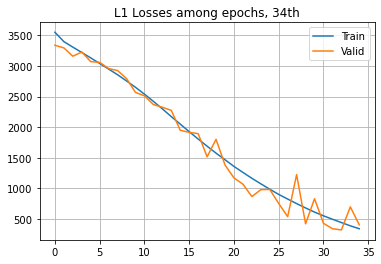

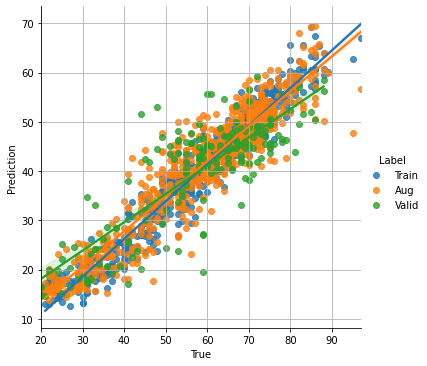

Epoch 36 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 364.0 sec [eval] 12.4 sec  [TRAIN]:: Loss=302.957 Mae=16.770 Rmse=17.174 Corr=0.976 
[AUGME]:: Loss=302.710 Mae=16.130 Rmse=17.176 
[VALID]:: Loss=703.656 Mae=23.711 Rmse=26.404 Corr=0.666 
Epoch 37 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 370.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=263.623 Mae=15.592 Rmse=15.988 Corr=0.976 
[AUGME]:: Loss=265.584 Mae=15.059 Rmse=16.057 
[VALID]:: Loss=308.017 Mae=15.120 Rmse=17.490 Corr=0.816 
Epoch 38 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 346.0 sec [eval] 12.3 sec  [TRAIN]:: Loss=229.989 Mae=14.540 Rmse=14.897 Corr=0.977 
[AUGME]:: Loss=236.299 Mae=14.035 Rmse=15.138 
[VALID]:: Loss=246.148 Mae=13.355 Rmse=15.614 Corr=0.830 
Epoch 39 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 403.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=199.203 Mae=13.481 Rmse=13.829 Corr=0.978 
[AUGME]:: Loss=202.955 Mae=12.997 Rmse=13.977 
[VALID]:: Loss=223.330 Mae=12.525 Rmse=14.890 Corr=0.809 
Epoch 40 / 1

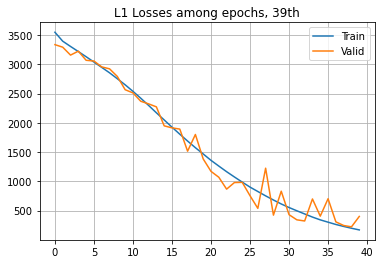

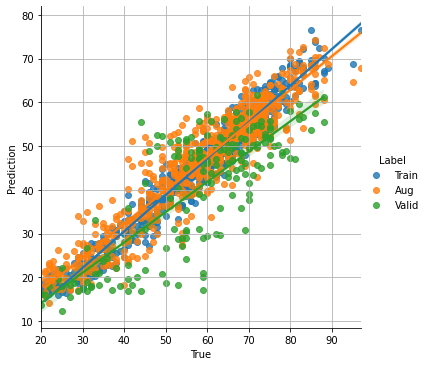

Epoch 41 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 375.0 sec [eval] 12.3 sec  [TRAIN]:: Loss=146.582 Mae=11.455 Rmse=11.774 Corr=0.978 
[AUGME]:: Loss=155.713 Mae=11.131 Rmse=12.208 
[VALID]:: Loss=284.027 Mae=14.523 Rmse=16.774 Corr=0.810 
Epoch 42 / 100, BEST MAE 10.000
[train] 50.5 sec [train] 390.9 sec [eval] 12.2 sec  [TRAIN]:: Loss=122.963 Mae=10.412 Rmse=10.728 Corr=0.979 
[AUGME]:: Loss=135.257 Mae=10.148 Rmse=11.311 
[VALID]:: Loss=172.692 Mae=10.806 Rmse=13.068 Corr=0.807 
Epoch 43 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 351.7 sec [eval] 12.3 sec  [TRAIN]:: Loss=105.151 Mae=9.551 Rmse=9.868 Corr=0.979 
[AUGME]:: Loss=113.094 Mae=9.307 Rmse=10.310 
[VALID]:: Loss=191.309 Mae=11.575 Rmse=13.755 Corr=0.804 
Epoch 44 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 341.5 sec [eval] 12.1 sec  Saving ...
[TRAIN]:: Loss=88.573 Mae=8.667 Rmse=9.001 Corr=0.978 
[AUGME]:: Loss=102.902 Mae=8.704 Rmse=9.776 
[VALID]:: Loss=118.594 Mae=8.842 Rmse=10.769 Corr=0.752 
Epoch 45 /

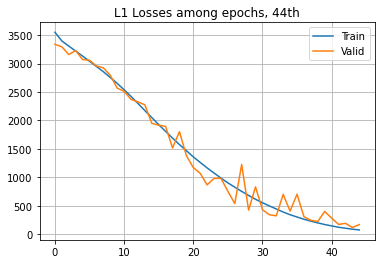

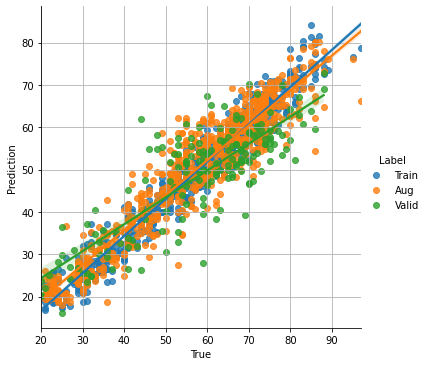

Epoch 46 / 100, BEST MAE 8.842
[train] 49.6 sec [train] 376.2 sec [eval] 12.3 sec  Saving ...
[TRAIN]:: Loss=62.819 Mae=7.037 Rmse=7.468 Corr=0.975 
[AUGME]:: Loss=74.545 Mae=7.237 Rmse=8.300 
[VALID]:: Loss=109.073 Mae=8.406 Rmse=10.359 Corr=0.796 
Epoch 47 / 100, BEST MAE 8.406
[train] 49.7 sec [train] 391.9 sec [eval] 12.1 sec  Saving ...
[TRAIN]:: Loss=51.306 Mae=6.321 Rmse=6.651 Corr=0.978 
[AUGME]:: Loss=66.663 Mae=6.844 Rmse=7.843 
[VALID]:: Loss=103.249 Mae=8.194 Rmse=10.069 Corr=0.816 
Epoch 48 / 100, BEST MAE 8.194
[train] 49.5 sec [train] 371.0 sec [eval] 12.2 sec  Saving ...
[TRAIN]:: Loss=45.604 Mae=5.897 Rmse=6.263 Corr=0.977 
[AUGME]:: Loss=64.159 Mae=6.536 Rmse=7.699 
[VALID]:: Loss=103.217 Mae=8.116 Rmse=10.047 Corr=0.782 
Epoch 49 / 100, BEST MAE 8.116
[train] 50.4 sec [train] 398.6 sec [eval] 12.2 sec  Saving ...
[TRAIN]:: Loss=38.180 Mae=5.296 Rmse=5.657 Corr=0.978 
[AUGME]:: Loss=52.196 Mae=5.918 Rmse=6.950 
[VALID]:: Loss=94.024 Mae=7.837 Rmse=9.548 Corr=0.824 
Ep

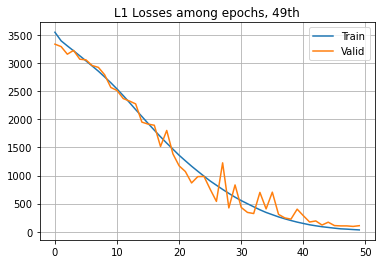

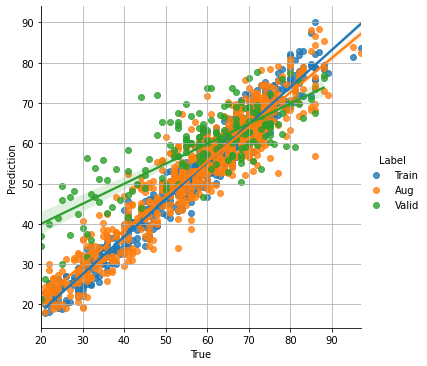

Epoch 51 / 100, BEST MAE 7.837
[train] 49.8 sec [train] 377.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=27.279 Mae=4.333 Rmse=4.715 Corr=0.978 
[AUGME]:: Loss=40.054 Mae=5.051 Rmse=6.082 
[VALID]:: Loss=169.482 Mae=10.737 Rmse=12.905 Corr=0.632 
Epoch 52 / 100, BEST MAE 7.837
[train] 49.5 sec [train] 348.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=24.336 Mae=4.050 Rmse=4.450 Corr=0.977 
[AUGME]:: Loss=41.118 Mae=5.094 Rmse=6.146 
[VALID]:: Loss=400.718 Mae=16.388 Rmse=19.787 Corr=0.301 
Epoch 53 / 100, BEST MAE 7.837
[train] 49.7 sec [train] 360.5 sec [eval] 12.3 sec  [TRAIN]:: Loss=21.982 Mae=3.794 Rmse=4.237 Corr=0.975 
[AUGME]:: Loss=37.395 Mae=4.748 Rmse=5.836 
[VALID]:: Loss=132.294 Mae=9.271 Rmse=11.362 Corr=0.734 
Epoch 54 / 100, BEST MAE 7.837
[train] 49.5 sec [train] 352.3 sec [eval] 12.1 sec  [TRAIN]:: Loss=20.611 Mae=3.675 Rmse=4.165 Corr=0.974 
[AUGME]:: Loss=41.250 Mae=4.921 Rmse=6.107 
[VALID]:: Loss=248.844 Mae=12.914 Rmse=15.615 Corr=0.477 
Epoch 55 / 100, BEST MAE 7.837
[train] 49

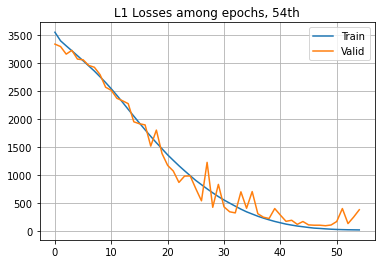

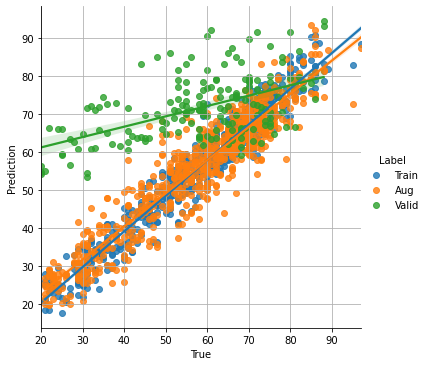

Epoch 56 / 100, BEST MAE 7.837
[train] 49.7 sec [train] 346.9 sec [eval] 12.1 sec  [TRAIN]:: Loss=18.078 Mae=3.392 Rmse=3.903 Corr=0.973 
[AUGME]:: Loss=35.993 Mae=4.675 Rmse=5.783 
[VALID]:: Loss=266.341 Mae=12.956 Rmse=16.111 Corr=0.478 
Epoch 57 / 100, BEST MAE 7.837
[train] 49.7 sec [train] 368.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=17.261 Mae=3.350 Rmse=3.827 Corr=0.973 
[AUGME]:: Loss=32.862 Mae=4.411 Rmse=5.525 
[VALID]:: Loss=105.972 Mae=8.248 Rmse=10.172 Corr=0.796 
Epoch 58 / 100, BEST MAE 7.837
[train] 49.4 sec [train] 336.6 sec [eval] 12.1 sec  [TRAIN]:: Loss=16.059 Mae=3.245 Rmse=3.702 Corr=0.973 
[AUGME]:: Loss=34.674 Mae=4.485 Rmse=5.682 
[VALID]:: Loss=115.698 Mae=8.804 Rmse=10.622 Corr=0.828 
Epoch 59 / 100, BEST MAE 7.837
[train] 50.3 sec [train] 340.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=17.490 Mae=3.341 Rmse=3.894 Corr=0.970 
[AUGME]:: Loss=37.401 Mae=4.662 Rmse=5.887 
[VALID]:: Loss=108.049 Mae=8.227 Rmse=10.279 Corr=0.812 
Epoch 60 / 100, BEST MAE 7.837
[train] 49.8

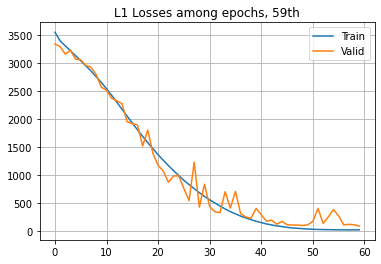

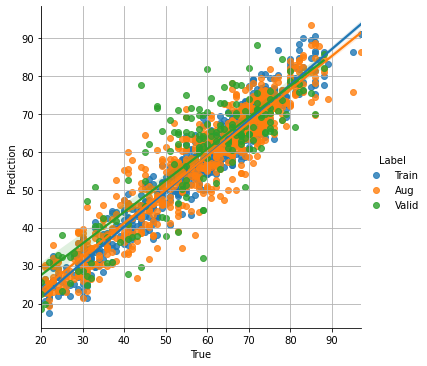

Epoch 61 / 100, BEST MAE 7.244
[train] 49.6 sec [train] 384.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=14.671 Mae=3.054 Rmse=3.537 Corr=0.974 
[AUGME]:: Loss=35.449 Mae=4.517 Rmse=5.691 
[VALID]:: Loss=107.552 Mae=8.324 Rmse=10.241 Corr=0.788 
Epoch 62 / 100, BEST MAE 7.244
[train] 49.8 sec [train] 404.1 sec [eval] 12.1 sec  [TRAIN]:: Loss=13.404 Mae=2.928 Rmse=3.358 Corr=0.976 
[AUGME]:: Loss=31.216 Mae=4.285 Rmse=5.330 
[VALID]:: Loss=201.900 Mae=11.647 Rmse=14.099 Corr=0.788 
Epoch 63 / 100, BEST MAE 7.244
[train] 49.6 sec [train] 383.4 sec [eval] 12.2 sec  [TRAIN]:: Loss=12.693 Mae=2.798 Rmse=3.243 Corr=0.977 
[AUGME]:: Loss=31.304 Mae=4.377 Rmse=5.436 
[VALID]:: Loss=87.583 Mae=7.327 Rmse=9.221 Corr=0.819 
Epoch 64 / 100, BEST MAE 7.244
[train] 49.5 sec [train] 391.7 sec [eval] 12.1 sec  [TRAIN]:: Loss=11.868 Mae=2.725 Rmse=3.119 Corr=0.979 
[AUGME]:: Loss=28.988 Mae=4.190 Rmse=5.187 
[VALID]:: Loss=92.160 Mae=7.571 Rmse=9.471 Corr=0.819 
Epoch 65 / 100, BEST MAE 7.244
[train] 49.4 sec

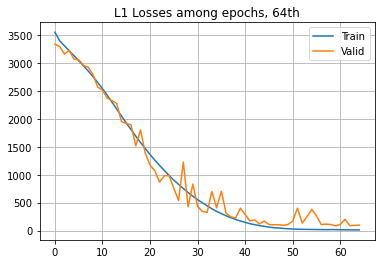

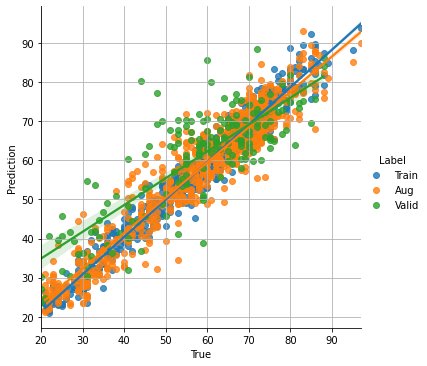

Epoch 66 / 100, BEST MAE 7.244
[train] 49.8 sec [train] 372.2 sec [eval] 12.2 sec  [TRAIN]:: Loss=10.728 Mae=2.587 Rmse=2.909 Corr=0.981 
[AUGME]:: Loss=26.885 Mae=3.910 Rmse=4.980 
[VALID]:: Loss=102.499 Mae=8.229 Rmse=10.009 Corr=0.802 
Epoch 67 / 100, BEST MAE 7.244
[train] 49.5 sec [train] 360.7 sec [eval] 12.2 sec  [TRAIN]:: Loss=11.564 Mae=2.681 Rmse=3.063 Corr=0.979 
[AUGME]:: Loss=29.588 Mae=4.073 Rmse=5.203 
[VALID]:: Loss=118.678 Mae=8.886 Rmse=10.790 Corr=0.810 
Epoch 68 / 100, BEST MAE 7.244
[train] 49.5 sec [train] 392.4 sec [eval] 12.2 sec  [TRAIN]:: Loss=10.690 Mae=2.594 Rmse=2.924 Corr=0.981 
[AUGME]:: Loss=26.165 Mae=3.901 Rmse=4.878 
[VALID]:: Loss=91.876 Mae=7.732 Rmse=9.464 Corr=0.818 
Epoch 69 / 100, BEST MAE 7.244
[train] 49.6 sec [train] 356.1 sec [eval] 12.2 sec  Saving ...
[TRAIN]:: Loss=10.600 Mae=2.574 Rmse=2.890 Corr=0.981 
[AUGME]:: Loss=27.646 Mae=4.060 Rmse=5.089 
[VALID]:: Loss=81.424 Mae=7.173 Rmse=8.829 Corr=0.828 
Epoch 70 / 100, BEST MAE 7.173
[train

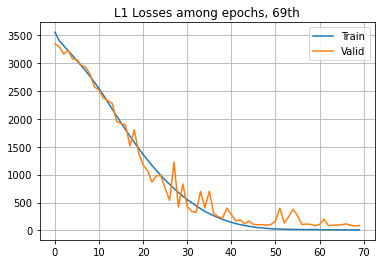

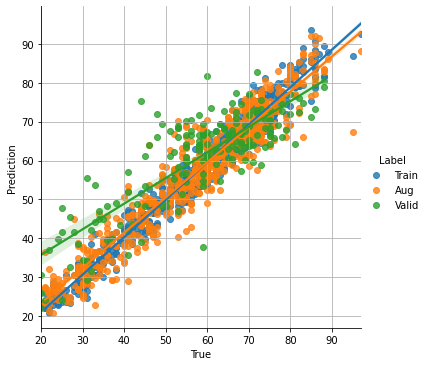

Epoch 71 / 100, BEST MAE 7.173
[train] 49.9 sec [train] 348.4 sec [eval] 12.1 sec  [TRAIN]:: Loss=9.934 Mae=2.483 Rmse=2.771 Corr=0.982 
[AUGME]:: Loss=26.680 Mae=3.866 Rmse=4.957 
[VALID]:: Loss=185.781 Mae=10.939 Rmse=13.500 Corr=0.734 
Epoch 72 / 100, BEST MAE 7.173
[train] 49.6 sec [train] 372.7 sec [eval] 12.5 sec  [TRAIN]:: Loss=10.093 Mae=2.532 Rmse=2.833 Corr=0.982 
[AUGME]:: Loss=27.127 Mae=3.971 Rmse=5.036 
[VALID]:: Loss=88.639 Mae=7.624 Rmse=9.288 Corr=0.826 
Epoch 73 / 100, BEST MAE 7.173
[train] 49.7 sec [train] 370.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=10.074 Mae=2.539 Rmse=2.835 Corr=0.982 
[AUGME]:: Loss=26.144 Mae=3.867 Rmse=4.827 
[VALID]:: Loss=101.691 Mae=8.181 Rmse=9.967 Corr=0.815 
Epoch 74 / 100, BEST MAE 7.173
[train] 49.3 sec [train] 329.8 sec [eval] 12.3 sec  [TRAIN]:: Loss=10.479 Mae=2.606 Rmse=2.938 Corr=0.981 
[AUGME]:: Loss=26.889 Mae=4.007 Rmse=5.001 
[VALID]:: Loss=164.844 Mae=10.180 Rmse=12.710 Corr=0.774 
Epoch 75 / 100, BEST MAE 7.173
[train] 49.7 se

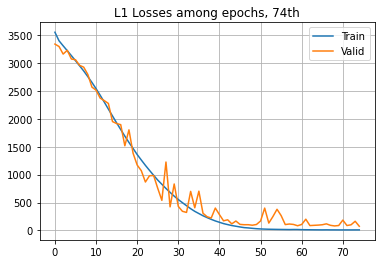

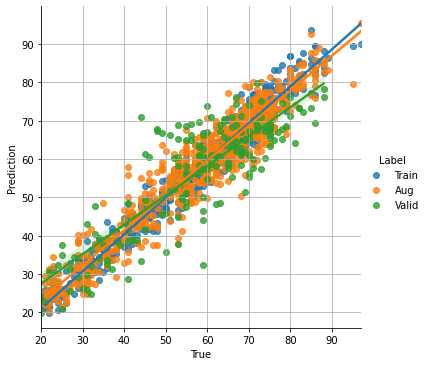

Epoch 76 / 100, BEST MAE 6.916
[train] 49.6 sec [train] 345.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=10.046 Mae=2.548 Rmse=2.854 Corr=0.982 
[AUGME]:: Loss=26.304 Mae=3.913 Rmse=4.927 
[VALID]:: Loss=159.952 Mae=10.269 Rmse=12.544 Corr=0.790 
Epoch 77 / 100, BEST MAE 6.916
[train] 49.9 sec [train] 363.7 sec [eval] 12.1 sec  [TRAIN]:: Loss=10.045 Mae=2.558 Rmse=2.864 Corr=0.982 
[AUGME]:: Loss=27.982 Mae=3.944 Rmse=5.037 
[VALID]:: Loss=98.323 Mae=7.983 Rmse=9.795 Corr=0.828 
Epoch 78 / 100, BEST MAE 6.916
[train] 49.5 sec [train] 362.9 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.385 Mae=2.438 Rmse=2.706 Corr=0.983 
[AUGME]:: Loss=27.625 Mae=4.065 Rmse=5.079 
[VALID]:: Loss=80.907 Mae=7.116 Rmse=8.914 Corr=0.836 
Epoch 79 / 100, BEST MAE 6.916
[train] 49.7 sec [train] 374.8 sec [eval] 12.3 sec  [TRAIN]:: Loss=9.943 Mae=2.527 Rmse=2.831 Corr=0.982 
[AUGME]:: Loss=23.173 Mae=3.649 Rmse=4.582 
[VALID]:: Loss=154.913 Mae=10.028 Rmse=12.345 Corr=0.791 
Epoch 80 / 100, BEST MAE 6.916
[train] 50.2 sec 

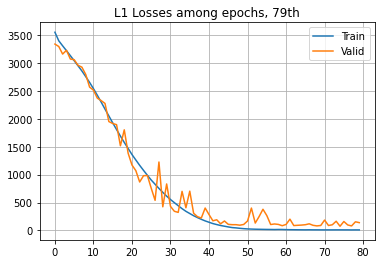

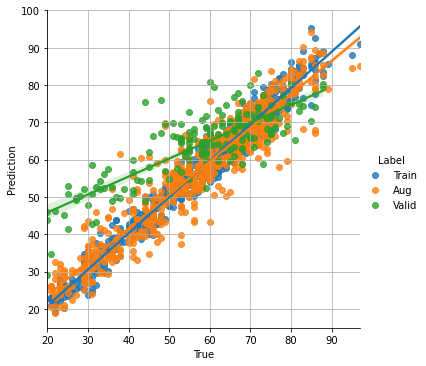

Epoch 81 / 100, BEST MAE 6.916
[train] 49.6 sec [train] 373.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.679 Mae=2.495 Rmse=2.795 Corr=0.982 
[AUGME]:: Loss=22.953 Mae=3.712 Rmse=4.567 
[VALID]:: Loss=239.165 Mae=12.397 Rmse=15.335 Corr=0.735 
Epoch 82 / 100, BEST MAE 6.916
[train] 49.6 sec [train] 353.3 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.778 Mae=2.484 Rmse=2.818 Corr=0.982 
[AUGME]:: Loss=25.045 Mae=3.897 Rmse=4.808 
[VALID]:: Loss=83.591 Mae=7.200 Rmse=9.053 Corr=0.835 
Epoch 83 / 100, BEST MAE 6.916
[train] 49.6 sec [train] 396.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.684 Mae=2.475 Rmse=2.810 Corr=0.982 
[AUGME]:: Loss=25.033 Mae=3.772 Rmse=4.825 
[VALID]:: Loss=75.530 Mae=6.970 Rmse=8.613 Corr=0.845 
Epoch 84 / 100, BEST MAE 6.916
[train] 49.9 sec [train] 357.4 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.431 Mae=2.453 Rmse=2.767 Corr=0.983 
[AUGME]:: Loss=24.825 Mae=3.789 Rmse=4.802 
[VALID]:: Loss=105.246 Mae=8.432 Rmse=10.182 Corr=0.829 
Epoch 85 / 100, BEST MAE 6.916
[train] 49.6 sec [tr

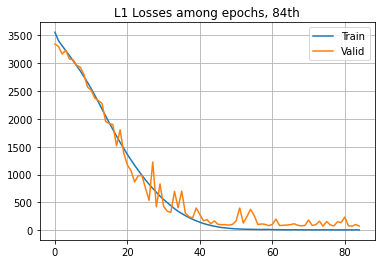

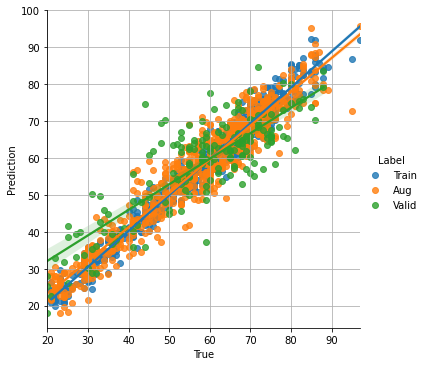

Epoch 86 / 100, BEST MAE 6.916
[train] 49.4 sec [train] 375.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.377 Mae=2.450 Rmse=2.775 Corr=0.983 
[AUGME]:: Loss=21.721 Mae=3.548 Rmse=4.498 
[VALID]:: Loss=99.900 Mae=7.959 Rmse=9.885 Corr=0.825 
Epoch 87 / 100, BEST MAE 6.916
[train] 49.5 sec [train] 355.3 sec [eval] 12.4 sec  [TRAIN]:: Loss=8.883 Mae=2.378 Rmse=2.683 Corr=0.984 
[AUGME]:: Loss=23.267 Mae=3.728 Rmse=4.684 
[VALID]:: Loss=210.053 Mae=11.546 Rmse=14.383 Corr=0.727 
Epoch 88 / 100, BEST MAE 6.916
[train] 49.6 sec [train] 359.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.354 Mae=2.464 Rmse=2.803 Corr=0.983 
[AUGME]:: Loss=23.610 Mae=3.711 Rmse=4.671 
[VALID]:: Loss=97.219 Mae=8.057 Rmse=9.773 Corr=0.815 
Epoch 89 / 100, BEST MAE 6.916
[train] 49.7 sec [train] 358.2 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.612 Mae=2.491 Rmse=2.856 Corr=0.983 
[AUGME]:: Loss=25.533 Mae=3.790 Rmse=4.829 
[VALID]:: Loss=160.224 Mae=10.235 Rmse=12.493 Corr=0.805 
Epoch 90 / 100, BEST MAE 6.916
[train] 49.5 sec [t

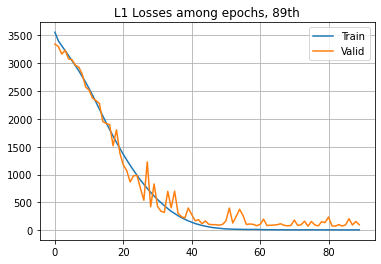

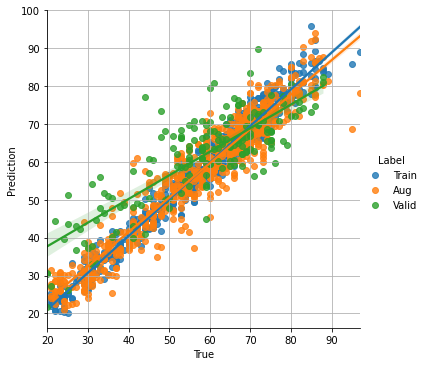

Epoch 91 / 100, BEST MAE 6.916
[train] 49.5 sec [train] 349.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.176 Mae=2.443 Rmse=2.788 Corr=0.983 
[AUGME]:: Loss=20.764 Mae=3.540 Rmse=4.411 
[VALID]:: Loss=119.147 Mae=8.952 Rmse=10.819 Corr=0.790 
Epoch 92 / 100, BEST MAE 6.916
[train] 49.7 sec [train] 363.3 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.237 Mae=2.434 Rmse=2.794 Corr=0.983 
[AUGME]:: Loss=22.208 Mae=3.569 Rmse=4.544 
[VALID]:: Loss=139.388 Mae=9.577 Rmse=11.697 Corr=0.788 
Epoch 93 / 100, BEST MAE 6.916
[train] 49.6 sec [train] 385.2 sec [eval] 12.8 sec  [TRAIN]:: Loss=9.017 Mae=2.431 Rmse=2.785 Corr=0.984 
[AUGME]:: Loss=22.376 Mae=3.581 Rmse=4.540 
[VALID]:: Loss=95.712 Mae=7.670 Rmse=9.631 Corr=0.838 
Epoch 94 / 100, BEST MAE 6.916
[train] 49.8 sec [train] 382.5 sec [eval] 12.3 sec  Saving ...
[TRAIN]:: Loss=8.455 Mae=2.322 Rmse=2.677 Corr=0.985 
[AUGME]:: Loss=22.878 Mae=3.659 Rmse=4.569 
[VALID]:: Loss=76.294 Mae=6.887 Rmse=8.567 Corr=0.846 
Epoch 95 / 100, BEST MAE 6.887
[train] 49

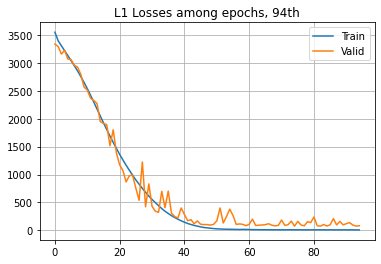

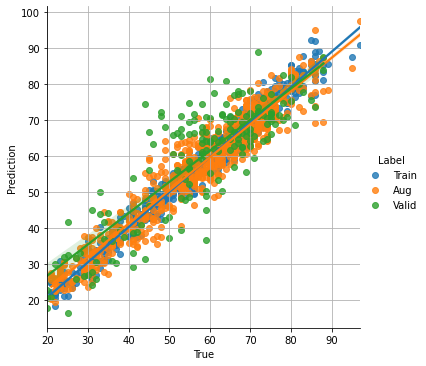

Epoch 96 / 100, BEST MAE 6.887
[train] 49.5 sec [train] 343.4 sec [eval] 12.1 sec  [TRAIN]:: Loss=7.391 Mae=2.138 Rmse=2.433 Corr=0.987 
[AUGME]:: Loss=21.539 Mae=3.516 Rmse=4.461 
[VALID]:: Loss=95.755 Mae=8.032 Rmse=9.705 Corr=0.818 
Epoch 97 / 100, BEST MAE 6.887
[train] 49.6 sec [train] 342.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=7.926 Mae=2.238 Rmse=2.591 Corr=0.986 
[AUGME]:: Loss=22.792 Mae=3.562 Rmse=4.583 
[VALID]:: Loss=106.733 Mae=7.913 Rmse=10.208 Corr=0.811 
Epoch 98 / 100, BEST MAE 6.887
[train] 49.6 sec [train] 370.7 sec [eval] 12.1 sec  [TRAIN]:: Loss=7.403 Mae=2.172 Rmse=2.510 Corr=0.987 
[AUGME]:: Loss=20.782 Mae=3.522 Rmse=4.382 
[VALID]:: Loss=143.137 Mae=9.488 Rmse=11.796 Corr=0.781 
Epoch 99 / 100, BEST MAE 6.887
[train] 49.5 sec [train] 350.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=6.852 Mae=2.076 Rmse=2.373 Corr=0.988 
[AUGME]:: Loss=19.651 Mae=3.360 Rmse=4.262 
[VALID]:: Loss=141.725 Mae=9.298 Rmse=11.789 Corr=0.784 
Epoch 100 / 100, BEST MAE 6.887
[train] 49.6 sec [

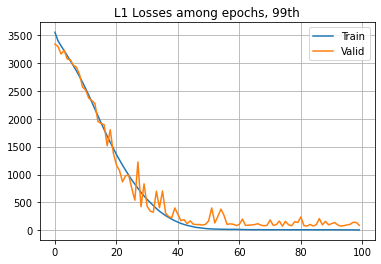

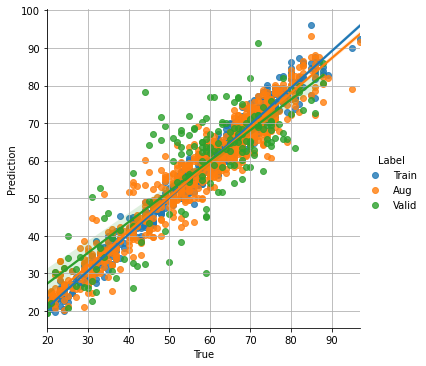

[eval] 8.3 sec  [HOLDOUT TEST]:: Loss=90.289 Mae=7.411 Rmse=9.351 Corr=0.824 


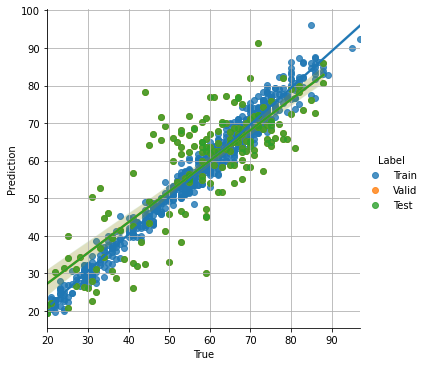

Fold 2 / 5
Model Resnet is selected.
Epoch 1 / 100, BEST MAE 10.000
[train] 50.5 sec [train] 355.2 sec [eval] 12.2 sec  [TRAIN]:: Loss=3390.259 Mae=55.917 Rmse=58.167 Corr=0.515 
[AUGME]:: Loss=3294.594 Mae=55.242 Rmse=57.337 
[VALID]:: Loss=3071.060 Mae=53.175 Rmse=55.309 Corr=0.466 
Epoch 2 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 359.9 sec [eval] 12.2 sec  [TRAIN]:: Loss=3231.222 Mae=54.707 Rmse=56.781 Corr=0.719 
[AUGME]:: Loss=3182.216 Mae=54.282 Rmse=56.348 
[VALID]:: Loss=3016.779 Mae=52.681 Rmse=54.817 Corr=0.548 
Epoch 3 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 369.1 sec [eval] 12.4 sec  [TRAIN]:: Loss=3129.756 Mae=53.844 Rmse=55.880 Corr=0.760 
[AUGME]:: Loss=3085.796 Mae=53.459 Rmse=55.485 
[VALID]:: Loss=3156.572 Mae=54.230 Rmse=56.086 Corr=0.708 
Epoch 4 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 350.3 sec [eval] 12.2 sec  [TRAIN]:: Loss=3036.093 Mae=53.021 Rmse=55.035 Corr=0.775 
[AUGME]:: Loss=2990.572 Mae=52.620 Rmse=54.620 
[VALID]:: Loss=3072.723 Ma

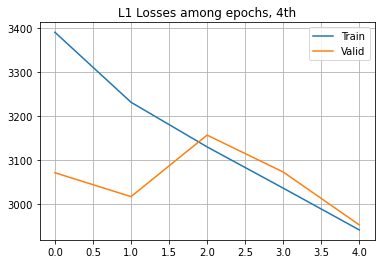

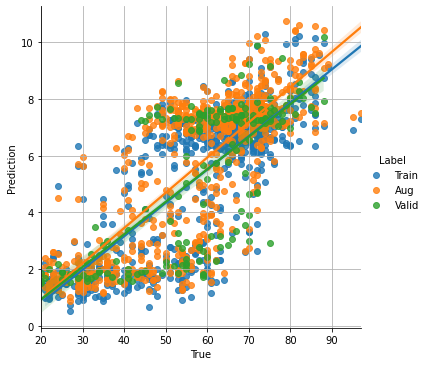

Epoch 6 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 369.6 sec [eval] 12.1 sec  [TRAIN]:: Loss=2843.380 Mae=51.297 Rmse=53.255 Corr=0.800 
[AUGME]:: Loss=2797.148 Mae=50.864 Rmse=52.819 
[VALID]:: Loss=2861.474 Mae=51.571 Rmse=53.399 Corr=0.765 
Epoch 7 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 345.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=2744.550 Mae=50.386 Rmse=52.319 Corr=0.799 
[AUGME]:: Loss=2697.792 Mae=49.940 Rmse=51.870 
[VALID]:: Loss=2657.361 Mae=49.594 Rmse=51.454 Corr=0.787 
Epoch 8 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 360.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=2643.495 Mae=49.450 Rmse=51.344 Corr=0.818 
[AUGME]:: Loss=2599.662 Mae=49.001 Rmse=50.914 
[VALID]:: Loss=2613.891 Mae=49.172 Rmse=51.032 Corr=0.708 
Epoch 9 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 372.5 sec [eval] 12.3 sec  [TRAIN]:: Loss=2546.485 Mae=48.519 Rmse=50.390 Corr=0.818 
[AUGME]:: Loss=2497.995 Mae=48.043 Rmse=49.906 
[VALID]:: Loss=2612.698 Mae=49.074 Rmse=51.020 Corr=0.623 
Epoc

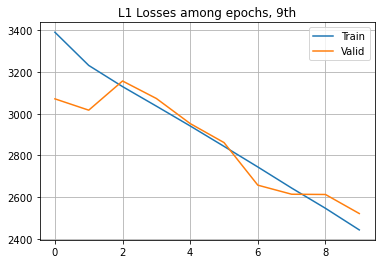

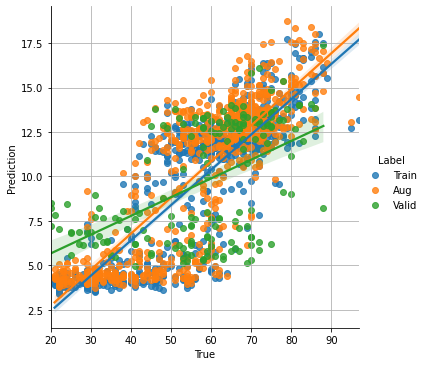

Epoch 11 / 100, BEST MAE 10.000
[train] 49.9 sec [train] 351.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=2340.804 Mae=46.530 Rmse=48.305 Corr=0.840 
[AUGME]:: Loss=2295.347 Mae=46.047 Rmse=47.833 
[VALID]:: Loss=2464.519 Mae=47.301 Rmse=49.535 Corr=0.400 
Epoch 12 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 357.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=2230.392 Mae=45.457 Rmse=47.148 Corr=0.860 
[AUGME]:: Loss=2183.698 Mae=44.934 Rmse=46.651 
[VALID]:: Loss=2321.987 Mae=46.274 Rmse=48.095 Corr=0.680 
Epoch 13 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 397.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=2118.538 Mae=44.343 Rmse=45.947 Corr=0.880 
[AUGME]:: Loss=2070.386 Mae=43.770 Rmse=45.421 
[VALID]:: Loss=1940.130 Mae=42.228 Rmse=43.952 Corr=0.801 
Epoch 14 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 354.6 sec [eval] 12.3 sec  [TRAIN]:: Loss=2002.293 Mae=43.154 Rmse=44.663 Corr=0.897 
[AUGME]:: Loss=1959.125 Mae=42.596 Rmse=44.178 
[VALID]:: Loss=2131.005 Mae=44.159 Rmse=46.075 Corr=0.621 


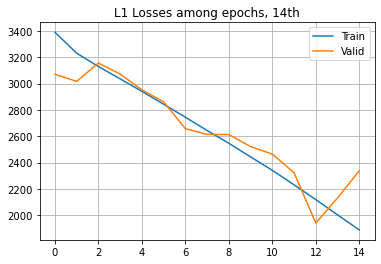

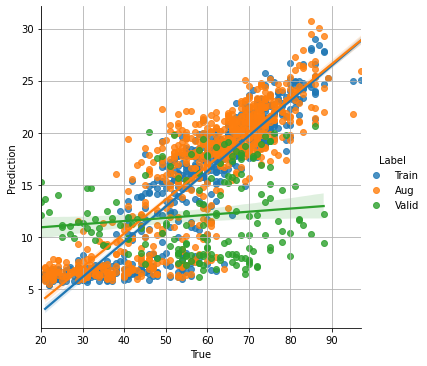

Epoch 16 / 100, BEST MAE 10.000
[train] 49.9 sec [train] 379.1 sec [eval] 12.1 sec  [TRAIN]:: Loss=1779.081 Mae=40.749 Rmse=42.090 Corr=0.918 
[AUGME]:: Loss=1736.679 Mae=40.123 Rmse=41.584 
[VALID]:: Loss=1694.607 Mae=39.041 Rmse=41.057 Corr=0.766 
Epoch 17 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 368.2 sec [eval] 12.3 sec  [TRAIN]:: Loss=1669.504 Mae=39.508 Rmse=40.767 Corr=0.928 
[AUGME]:: Loss=1628.710 Mae=38.878 Rmse=40.264 
[VALID]:: Loss=2064.846 Mae=42.909 Rmse=45.323 Corr=0.376 
Epoch 18 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 363.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=1566.531 Mae=38.303 Rmse=39.484 Corr=0.936 
[AUGME]:: Loss=1528.832 Mae=37.623 Rmse=39.004 
[VALID]:: Loss=1662.472 Mae=39.089 Rmse=40.684 Corr=0.840 
Epoch 19 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 372.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=1459.602 Mae=36.984 Rmse=38.105 Corr=0.938 
[AUGME]:: Loss=1419.993 Mae=36.276 Rmse=37.583 
[VALID]:: Loss=1701.107 Mae=39.364 Rmse=41.155 Corr=0.714 


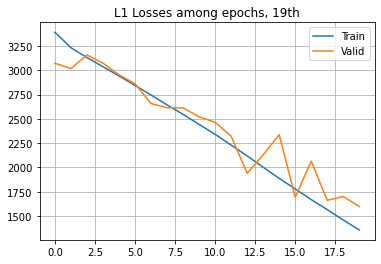

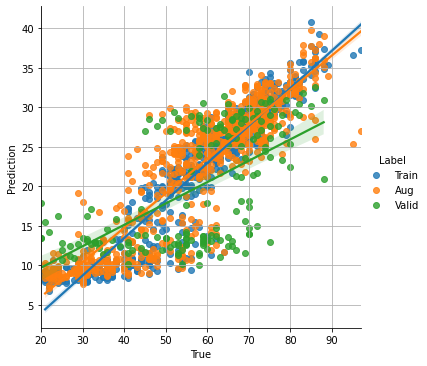

Epoch 21 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 372.8 sec [eval] 12.3 sec  [TRAIN]:: Loss=1265.562 Mae=34.457 Rmse=35.466 Corr=0.945 
[AUGME]:: Loss=1232.675 Mae=33.753 Rmse=34.999 
[VALID]:: Loss=1646.833 Mae=37.966 Rmse=40.471 Corr=0.453 
Epoch 22 / 100, BEST MAE 10.000
[train] 50.5 sec [train] 367.4 sec [eval] 12.3 sec  [TRAIN]:: Loss=1170.979 Mae=33.162 Rmse=34.106 Corr=0.949 
[AUGME]:: Loss=1145.374 Mae=32.515 Rmse=33.729 
[VALID]:: Loss=1111.686 Mae=31.704 Rmse=33.260 Corr=0.818 
Epoch 23 / 100, BEST MAE 10.000
[train] 50.0 sec [train] 375.8 sec [eval] 12.3 sec  [TRAIN]:: Loss=1080.954 Mae=31.875 Rmse=32.760 Corr=0.953 
[AUGME]:: Loss=1057.970 Mae=31.214 Rmse=32.408 
[VALID]:: Loss=1205.054 Mae=32.916 Rmse=34.629 Corr=0.756 
Epoch 24 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 366.8 sec [eval] 12.3 sec  [TRAIN]:: Loss=994.642 Mae=30.581 Rmse=31.414 Corr=0.956 
[AUGME]:: Loss=974.555 Mae=29.984 Rmse=31.094 
[VALID]:: Loss=891.671 Mae=27.836 Rmse=29.756 Corr=0.827 
Epo

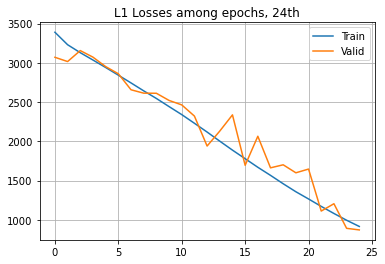

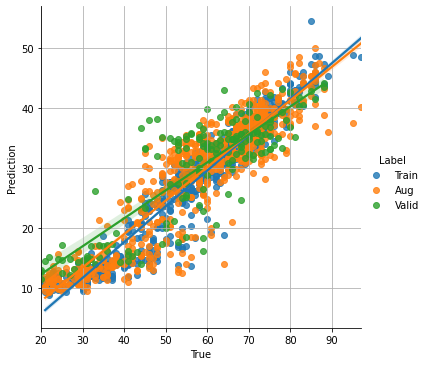

Epoch 26 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 346.6 sec [eval] 12.4 sec  [TRAIN]:: Loss=835.097 Mae=28.038 Rmse=28.761 Corr=0.963 
[AUGME]:: Loss=818.076 Mae=27.416 Rmse=28.470 
[VALID]:: Loss=784.026 Mae=25.431 Rmse=27.871 Corr=0.778 
Epoch 27 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 366.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=760.067 Mae=26.751 Rmse=27.425 Corr=0.964 
[AUGME]:: Loss=746.473 Mae=26.077 Rmse=27.184 
[VALID]:: Loss=1400.524 Mae=34.282 Rmse=37.257 Corr=0.330 
Epoch 28 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 342.5 sec [eval] 12.3 sec  [TRAIN]:: Loss=687.287 Mae=25.449 Rmse=26.064 Corr=0.968 
[AUGME]:: Loss=676.333 Mae=24.796 Rmse=25.864 
[VALID]:: Loss=909.038 Mae=28.404 Rmse=30.065 Corr=0.798 
Epoch 29 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 379.9 sec [eval] 12.2 sec  [TRAIN]:: Loss=624.171 Mae=24.211 Rmse=24.823 Corr=0.965 
[AUGME]:: Loss=619.143 Mae=23.647 Rmse=24.729 
[VALID]:: Loss=852.640 Mae=27.378 Rmse=29.117 Corr=0.785 
Epoch 30 / 

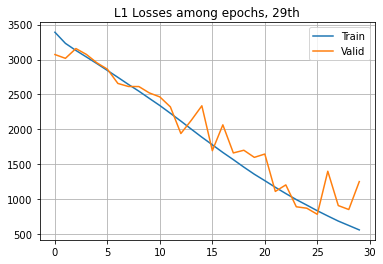

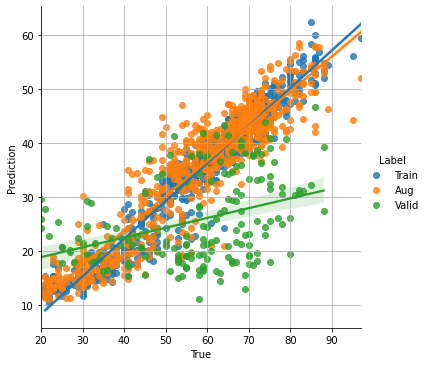

Epoch 31 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 349.5 sec [eval] 12.7 sec  [TRAIN]:: Loss=506.725 Mae=21.810 Rmse=22.335 Corr=0.972 
[AUGME]:: Loss=503.521 Mae=21.253 Rmse=22.260 
[VALID]:: Loss=426.530 Mae=18.629 Rmse=20.559 Corr=0.837 
Epoch 32 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 355.9 sec [eval] 12.3 sec  [TRAIN]:: Loss=455.532 Mae=20.632 Rmse=21.156 Corr=0.969 
[AUGME]:: Loss=447.469 Mae=19.940 Rmse=20.965 
[VALID]:: Loss=388.058 Mae=17.171 Rmse=19.585 Corr=0.817 
Epoch 33 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 371.4 sec [eval] 12.2 sec  [TRAIN]:: Loss=396.033 Mae=19.213 Rmse=19.699 Corr=0.971 
[AUGME]:: Loss=397.134 Mae=18.726 Rmse=19.736 
[VALID]:: Loss=335.558 Mae=15.541 Rmse=18.175 Corr=0.782 
Epoch 34 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 361.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=353.080 Mae=18.115 Rmse=18.575 Corr=0.971 
[AUGME]:: Loss=350.599 Mae=17.525 Rmse=18.503 
[VALID]:: Loss=360.622 Mae=17.076 Rmse=18.880 Corr=0.828 
Epoch 35 / 1

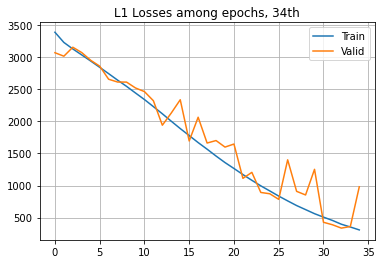

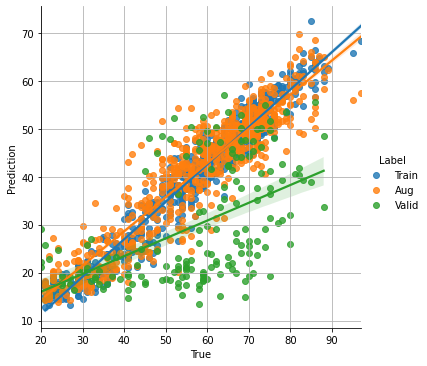

Epoch 36 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 373.9 sec [eval] 12.2 sec  [TRAIN]:: Loss=271.908 Mae=15.867 Rmse=16.245 Corr=0.976 
[AUGME]:: Loss=273.191 Mae=15.409 Rmse=16.309 
[VALID]:: Loss=839.283 Mae=26.124 Rmse=28.813 Corr=0.629 
Epoch 37 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 353.3 sec [eval] 12.3 sec  [TRAIN]:: Loss=234.488 Mae=14.722 Rmse=15.049 Corr=0.979 
[AUGME]:: Loss=244.827 Mae=14.351 Rmse=15.411 
[VALID]:: Loss=226.112 Mae=12.725 Rmse=14.927 Corr=0.767 
Epoch 38 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 366.4 sec [eval] 12.5 sec  [TRAIN]:: Loss=202.092 Mae=13.582 Rmse=13.931 Corr=0.977 
[AUGME]:: Loss=211.674 Mae=13.233 Rmse=14.282 
[VALID]:: Loss=1322.285 Mae=32.508 Rmse=36.237 Corr=-0.732 
Epoch 39 / 100, BEST MAE 10.000
[train] 50.5 sec [train] 351.0 sec [eval] 12.3 sec  [TRAIN]:: Loss=173.130 Mae=12.528 Rmse=12.857 Corr=0.978 
[AUGME]:: Loss=183.890 Mae=12.274 Rmse=13.284 
[VALID]:: Loss=172.179 Mae=10.922 Rmse=13.023 Corr=0.757 
Epoch 40 /

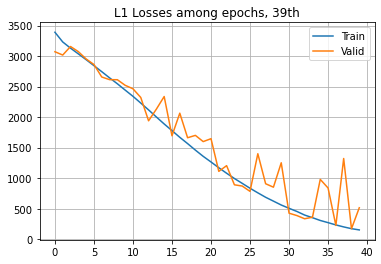

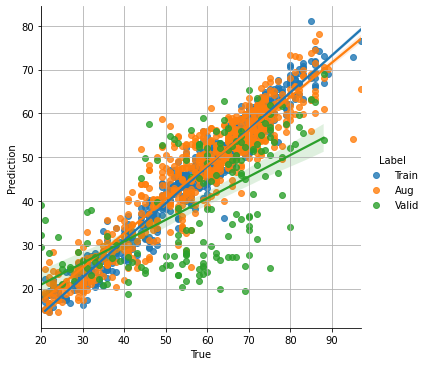

Epoch 41 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 383.0 sec [eval] 12.4 sec  [TRAIN]:: Loss=129.176 Mae=10.685 Rmse=11.027 Corr=0.978 
[AUGME]:: Loss=141.275 Mae=10.553 Rmse=11.585 
[VALID]:: Loss=209.666 Mae=12.352 Rmse=14.389 Corr=0.826 
Epoch 42 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 360.6 sec [eval] 12.4 sec  Saving ...
[TRAIN]:: Loss=107.524 Mae=9.621 Rmse=10.005 Corr=0.976 
[AUGME]:: Loss=122.736 Mae=9.734 Rmse=10.794 
[VALID]:: Loss=136.414 Mae=9.649 Rmse=11.606 Corr=0.731 
Epoch 43 / 100, BEST MAE 9.649
[train] 49.8 sec [train] 355.6 sec [eval] 12.2 sec  Saving ...
[TRAIN]:: Loss=90.973 Mae=8.777 Rmse=9.121 Corr=0.977 
[AUGME]:: Loss=101.927 Mae=8.701 Rmse=9.750 
[VALID]:: Loss=115.063 Mae=8.710 Rmse=10.606 Corr=0.822 
Epoch 44 / 100, BEST MAE 8.710
[train] 49.5 sec [train] 381.9 sec [eval] 12.1 sec  Saving ...
[TRAIN]:: Loss=77.487 Mae=8.046 Rmse=8.355 Corr=0.979 
[AUGME]:: Loss=94.676 Mae=8.160 Rmse=9.381 
[VALID]:: Loss=113.240 Mae=8.639 Rmse=10.535 Corr=0.79

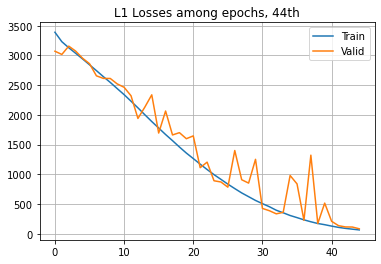

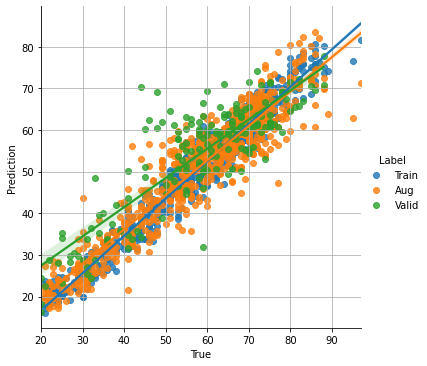

Epoch 46 / 100, BEST MAE 7.469
[train] 49.6 sec [train] 370.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=53.734 Mae=6.492 Rmse=6.862 Corr=0.978 
[AUGME]:: Loss=66.819 Mae=6.816 Rmse=7.848 
[VALID]:: Loss=104.319 Mae=8.436 Rmse=10.153 Corr=0.836 
Epoch 47 / 100, BEST MAE 7.469
[train] 49.4 sec [train] 369.5 sec [eval] 12.4 sec  [TRAIN]:: Loss=43.946 Mae=5.796 Rmse=6.103 Corr=0.980 
[AUGME]:: Loss=59.583 Mae=6.298 Rmse=7.339 
[VALID]:: Loss=125.505 Mae=9.355 Rmse=11.153 Corr=0.766 
Epoch 48 / 100, BEST MAE 7.469
[train] 49.7 sec [train] 349.7 sec [eval] 12.2 sec  [TRAIN]:: Loss=38.080 Mae=5.321 Rmse=5.639 Corr=0.980 
[AUGME]:: Loss=56.036 Mae=6.129 Rmse=7.214 
[VALID]:: Loss=99.999 Mae=8.168 Rmse=9.896 Corr=0.797 
Epoch 49 / 100, BEST MAE 7.469
[train] 49.5 sec [train] 350.9 sec [eval] 12.3 sec  [TRAIN]:: Loss=32.626 Mae=4.841 Rmse=5.163 Corr=0.980 
[AUGME]:: Loss=52.933 Mae=5.813 Rmse=7.001 
[VALID]:: Loss=155.447 Mae=10.137 Rmse=12.365 Corr=0.665 
Epoch 50 / 100, BEST MAE 7.469
[train] 49.9 s

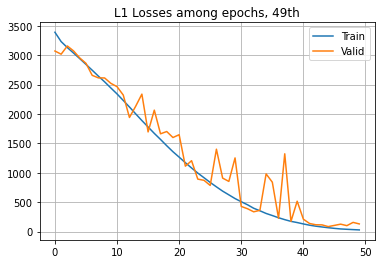

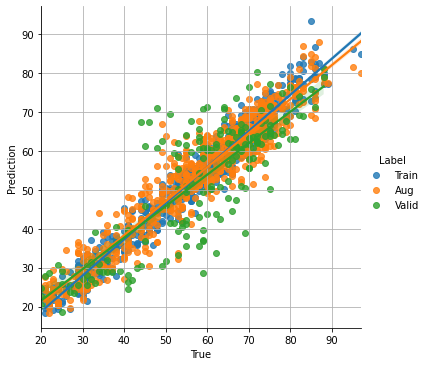

Epoch 51 / 100, BEST MAE 7.469
[train] 49.8 sec [train] 385.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=24.533 Mae=4.076 Rmse=4.432 Corr=0.979 
[AUGME]:: Loss=42.863 Mae=5.220 Rmse=6.288 
[VALID]:: Loss=93.365 Mae=7.930 Rmse=9.596 Corr=0.815 
Epoch 52 / 100, BEST MAE 7.469
[train] 49.4 sec [train] 339.6 sec [eval] 12.7 sec  [TRAIN]:: Loss=20.650 Mae=3.707 Rmse=4.044 Corr=0.980 
[AUGME]:: Loss=37.249 Mae=4.755 Rmse=5.832 
[VALID]:: Loss=109.436 Mae=8.622 Rmse=10.374 Corr=0.776 
Epoch 53 / 100, BEST MAE 7.469
[train] 49.7 sec [train] 355.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=18.116 Mae=3.439 Rmse=3.799 Corr=0.979 
[AUGME]:: Loss=35.349 Mae=4.635 Rmse=5.683 
[VALID]:: Loss=88.388 Mae=7.477 Rmse=9.265 Corr=0.815 
Epoch 54 / 100, BEST MAE 7.469
[train] 49.5 sec [train] 349.1 sec [eval] 12.1 sec  [TRAIN]:: Loss=17.929 Mae=3.401 Rmse=3.825 Corr=0.977 
[AUGME]:: Loss=31.109 Mae=4.346 Rmse=5.367 
[VALID]:: Loss=92.751 Mae=7.847 Rmse=9.537 Corr=0.819 
Epoch 55 / 100, BEST MAE 7.469
[train] 49.7 sec [t

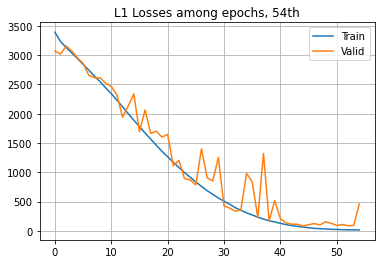

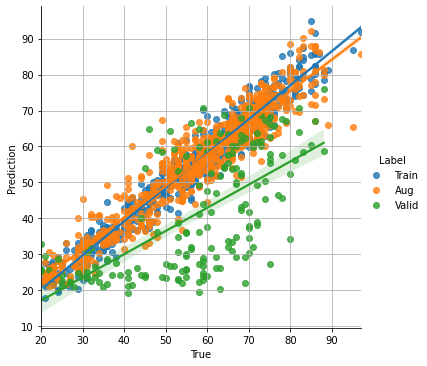

Epoch 56 / 100, BEST MAE 7.469
[train] 50.0 sec [train] 378.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=14.783 Mae=3.057 Rmse=3.458 Corr=0.978 
[AUGME]:: Loss=29.829 Mae=4.208 Rmse=5.228 
[VALID]:: Loss=196.802 Mae=11.095 Rmse=13.866 Corr=0.662 
Epoch 57 / 100, BEST MAE 7.469
[train] 49.9 sec [train] 336.8 sec [eval] 12.2 sec  Saving ...
[TRAIN]:: Loss=15.243 Mae=3.104 Rmse=3.539 Corr=0.976 
[AUGME]:: Loss=33.427 Mae=4.456 Rmse=5.593 
[VALID]:: Loss=87.675 Mae=7.466 Rmse=9.251 Corr=0.818 
Epoch 58 / 100, BEST MAE 7.466
[train] 49.7 sec [train] 350.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=16.154 Mae=3.232 Rmse=3.730 Corr=0.973 
[AUGME]:: Loss=33.437 Mae=4.467 Rmse=5.627 
[VALID]:: Loss=86.424 Mae=7.576 Rmse=9.222 Corr=0.848 
Epoch 59 / 100, BEST MAE 7.466
[train] 49.7 sec [train] 375.6 sec [eval] 12.1 sec  [TRAIN]:: Loss=15.379 Mae=3.198 Rmse=3.695 Corr=0.973 
[AUGME]:: Loss=31.976 Mae=4.301 Rmse=5.451 
[VALID]:: Loss=197.113 Mae=11.188 Rmse=13.874 Corr=0.672 
Epoch 60 / 100, BEST MAE 7.466
[tra

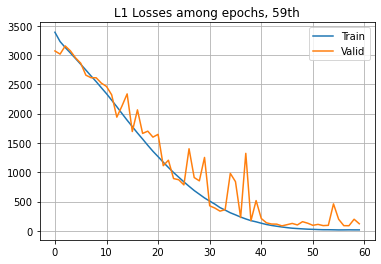

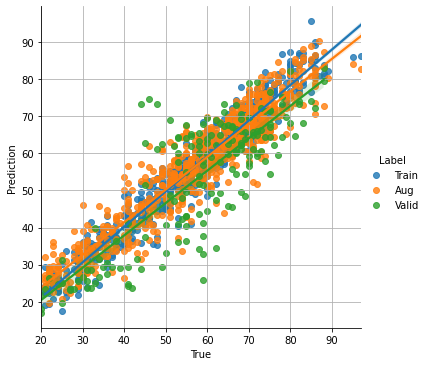

Epoch 61 / 100, BEST MAE 7.466
[train] 49.9 sec [train] 378.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=14.995 Mae=3.087 Rmse=3.632 Corr=0.973 
[AUGME]:: Loss=29.948 Mae=4.216 Rmse=5.303 
[VALID]:: Loss=677.878 Mae=21.747 Rmse=25.846 Corr=0.484 
Epoch 62 / 100, BEST MAE 7.466
[train] 49.7 sec [train] 372.8 sec [eval] 12.3 sec  [TRAIN]:: Loss=14.225 Mae=3.026 Rmse=3.521 Corr=0.975 
[AUGME]:: Loss=29.581 Mae=4.242 Rmse=5.235 
[VALID]:: Loss=115.102 Mae=8.432 Rmse=10.609 Corr=0.813 
Epoch 63 / 100, BEST MAE 7.466
[train] 49.6 sec [train] 383.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=12.748 Mae=2.857 Rmse=3.310 Corr=0.977 
[AUGME]:: Loss=28.841 Mae=4.199 Rmse=5.215 
[VALID]:: Loss=157.880 Mae=10.185 Rmse=12.456 Corr=0.673 
Epoch 64 / 100, BEST MAE 7.466
[train] 49.8 sec [train] 399.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=14.545 Mae=3.034 Rmse=3.549 Corr=0.974 
[AUGME]:: Loss=33.852 Mae=4.405 Rmse=5.566 
[VALID]:: Loss=97.121 Mae=7.967 Rmse=9.767 Corr=0.824 
Epoch 65 / 100, BEST MAE 7.466
[train] 50.0 

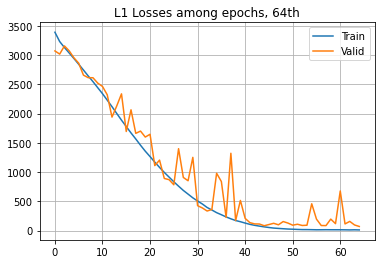

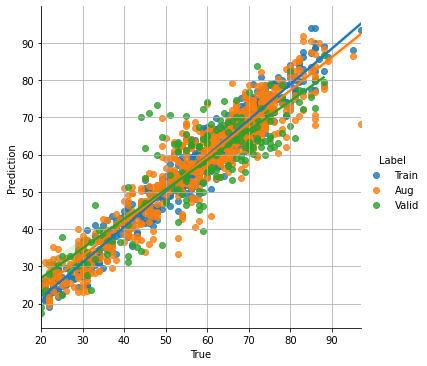

Epoch 66 / 100, BEST MAE 6.778
[train] 49.6 sec [train] 340.6 sec [eval] 12.1 sec  [TRAIN]:: Loss=10.599 Mae=2.581 Rmse=2.919 Corr=0.981 
[AUGME]:: Loss=23.763 Mae=3.789 Rmse=4.692 
[VALID]:: Loss=78.239 Mae=6.936 Rmse=8.706 Corr=0.842 
Epoch 67 / 100, BEST MAE 6.778
[train] 50.2 sec [train] 359.8 sec [eval] 12.5 sec  [TRAIN]:: Loss=10.060 Mae=2.515 Rmse=2.813 Corr=0.982 
[AUGME]:: Loss=26.043 Mae=3.919 Rmse=4.904 
[VALID]:: Loss=77.019 Mae=6.999 Rmse=8.708 Corr=0.863 
Epoch 68 / 100, BEST MAE 6.778
[train] 49.8 sec [train] 393.3 sec [eval] 12.2 sec  [TRAIN]:: Loss=10.353 Mae=2.522 Rmse=2.872 Corr=0.981 
[AUGME]:: Loss=24.628 Mae=3.800 Rmse=4.785 
[VALID]:: Loss=79.071 Mae=7.269 Rmse=8.834 Corr=0.865 
Epoch 69 / 100, BEST MAE 6.778
[train] 49.7 sec [train] 373.2 sec [eval] 12.2 sec  [TRAIN]:: Loss=10.051 Mae=2.511 Rmse=2.791 Corr=0.982 
[AUGME]:: Loss=26.797 Mae=3.939 Rmse=5.001 
[VALID]:: Loss=78.598 Mae=7.183 Rmse=8.783 Corr=0.847 
Epoch 70 / 100, BEST MAE 6.778
[train] 49.7 sec [tra

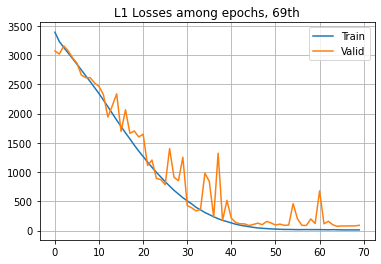

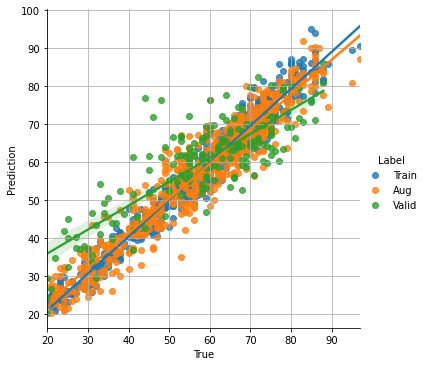

Epoch 71 / 100, BEST MAE 6.778
[train] 50.0 sec [train] 343.6 sec [eval] 12.3 sec  [TRAIN]:: Loss=9.477 Mae=2.431 Rmse=2.699 Corr=0.983 
[AUGME]:: Loss=25.809 Mae=3.911 Rmse=4.874 
[VALID]:: Loss=150.654 Mae=9.669 Rmse=12.191 Corr=0.820 
Epoch 72 / 100, BEST MAE 6.778
[train] 49.9 sec [train] 375.4 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.867 Mae=2.511 Rmse=2.800 Corr=0.982 
[AUGME]:: Loss=26.477 Mae=3.857 Rmse=4.923 
[VALID]:: Loss=92.665 Mae=7.506 Rmse=9.539 Corr=0.855 
Epoch 73 / 100, BEST MAE 6.778
[train] 49.7 sec [train] 368.3 sec [eval] 13.0 sec  [TRAIN]:: Loss=9.747 Mae=2.492 Rmse=2.788 Corr=0.982 
[AUGME]:: Loss=28.557 Mae=4.136 Rmse=5.150 
[VALID]:: Loss=79.765 Mae=7.053 Rmse=8.787 Corr=0.842 
Epoch 74 / 100, BEST MAE 6.778
[train] 50.1 sec [train] 352.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=10.990 Mae=2.587 Rmse=2.971 Corr=0.980 
[AUGME]:: Loss=24.606 Mae=3.837 Rmse=4.777 
[VALID]:: Loss=74.971 Mae=6.837 Rmse=8.570 Corr=0.853 
Epoch 75 / 100, BEST MAE 6.778
[train] 49.7 sec [trai

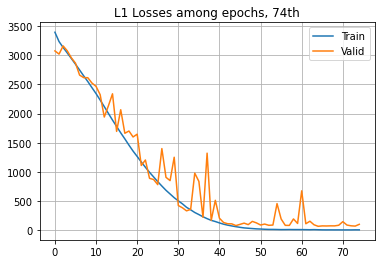

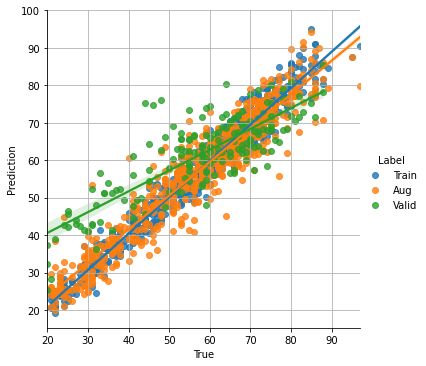

Epoch 76 / 100, BEST MAE 6.778
[train] 50.0 sec [train] 355.2 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.627 Mae=2.450 Rmse=2.748 Corr=0.983 
[AUGME]:: Loss=25.750 Mae=3.916 Rmse=4.848 
[VALID]:: Loss=331.444 Mae=14.814 Rmse=18.082 Corr=0.527 
Epoch 77 / 100, BEST MAE 6.778
[train] 49.7 sec [train] 370.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=10.018 Mae=2.529 Rmse=2.849 Corr=0.982 
[AUGME]:: Loss=25.874 Mae=3.932 Rmse=4.896 
[VALID]:: Loss=106.824 Mae=8.004 Rmse=10.170 Corr=0.821 
Epoch 78 / 100, BEST MAE 6.778
[train] 50.0 sec [train] 370.7 sec [eval] 12.2 sec  Saving ...
[TRAIN]:: Loss=10.164 Mae=2.532 Rmse=2.875 Corr=0.981 
[AUGME]:: Loss=24.942 Mae=3.888 Rmse=4.839 
[VALID]:: Loss=74.117 Mae=6.714 Rmse=8.516 Corr=0.857 
Epoch 79 / 100, BEST MAE 6.714
[train] 49.6 sec [train] 391.9 sec [eval] 12.2 sec  [TRAIN]:: Loss=10.150 Mae=2.554 Rmse=2.882 Corr=0.982 
[AUGME]:: Loss=26.074 Mae=3.900 Rmse=4.946 
[VALID]:: Loss=148.745 Mae=9.651 Rmse=12.091 Corr=0.790 
Epoch 80 / 100, BEST MAE 6.714
[tra

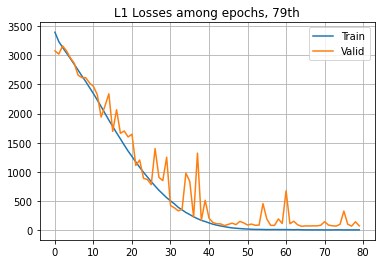

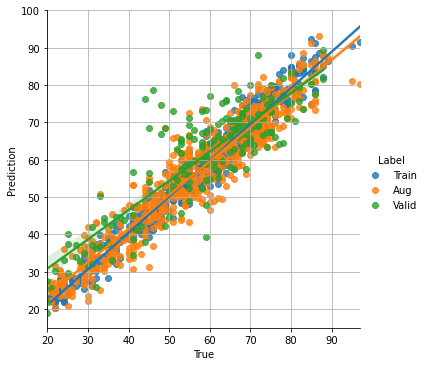

Epoch 81 / 100, BEST MAE 6.714
[train] 49.8 sec [train] 370.7 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.706 Mae=2.461 Rmse=2.794 Corr=0.982 
[AUGME]:: Loss=22.789 Mae=3.693 Rmse=4.631 
[VALID]:: Loss=71.583 Mae=6.845 Rmse=8.404 Corr=0.851 
Epoch 82 / 100, BEST MAE 6.714
[train] 49.6 sec [train] 363.5 sec [eval] 12.3 sec  [TRAIN]:: Loss=9.129 Mae=2.380 Rmse=2.682 Corr=0.983 
[AUGME]:: Loss=25.380 Mae=3.831 Rmse=4.860 
[VALID]:: Loss=157.063 Mae=9.926 Rmse=12.450 Corr=0.765 
Epoch 83 / 100, BEST MAE 6.714
[train] 49.6 sec [train] 338.1 sec [eval] 12.3 sec  [TRAIN]:: Loss=9.357 Mae=2.451 Rmse=2.718 Corr=0.983 
[AUGME]:: Loss=25.052 Mae=3.799 Rmse=4.870 
[VALID]:: Loss=73.647 Mae=6.740 Rmse=8.539 Corr=0.852 
Epoch 84 / 100, BEST MAE 6.714
[train] 49.7 sec [train] 362.5 sec [eval] 12.3 sec  Saving ...
[TRAIN]:: Loss=9.151 Mae=2.401 Rmse=2.687 Corr=0.983 
[AUGME]:: Loss=22.008 Mae=3.502 Rmse=4.513 
[VALID]:: Loss=72.379 Mae=6.600 Rmse=8.364 Corr=0.866 
Epoch 85 / 100, BEST MAE 6.600
[train] 49.9

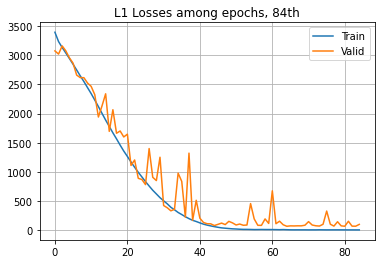

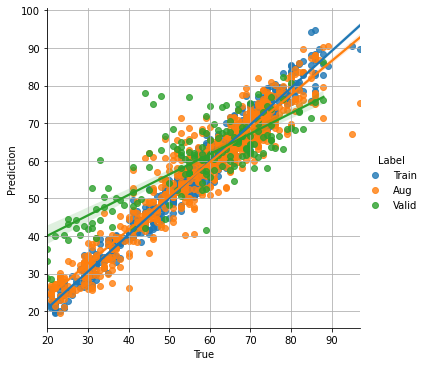

Epoch 86 / 100, BEST MAE 6.600
[train] 49.6 sec [train] 357.5 sec [eval] 12.4 sec  [TRAIN]:: Loss=8.877 Mae=2.370 Rmse=2.670 Corr=0.984 
[AUGME]:: Loss=21.105 Mae=3.587 Rmse=4.439 
[VALID]:: Loss=78.127 Mae=6.849 Rmse=8.705 Corr=0.850 
Epoch 87 / 100, BEST MAE 6.600
[train] 50.0 sec [train] 352.0 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.209 Mae=2.432 Rmse=2.734 Corr=0.983 
[AUGME]:: Loss=23.948 Mae=3.746 Rmse=4.743 
[VALID]:: Loss=146.758 Mae=9.498 Rmse=11.975 Corr=0.777 
Epoch 88 / 100, BEST MAE 6.600
[train] 50.4 sec [train] 360.5 sec [eval] 12.4 sec  [TRAIN]:: Loss=10.101 Mae=2.522 Rmse=2.892 Corr=0.982 
[AUGME]:: Loss=22.930 Mae=3.702 Rmse=4.656 
[VALID]:: Loss=92.006 Mae=7.457 Rmse=9.450 Corr=0.832 
Epoch 89 / 100, BEST MAE 6.600
[train] 49.8 sec [train] 357.3 sec [eval] 12.2 sec  [TRAIN]:: Loss=9.665 Mae=2.496 Rmse=2.856 Corr=0.982 
[AUGME]:: Loss=23.265 Mae=3.710 Rmse=4.635 
[VALID]:: Loss=499.983 Mae=18.688 Rmse=22.116 Corr=0.450 
Epoch 90 / 100, BEST MAE 6.600
[train] 50.3 sec [t

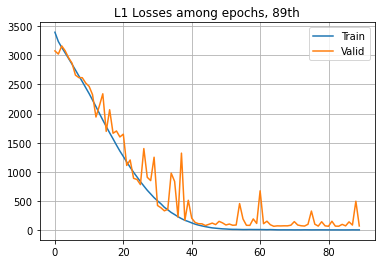

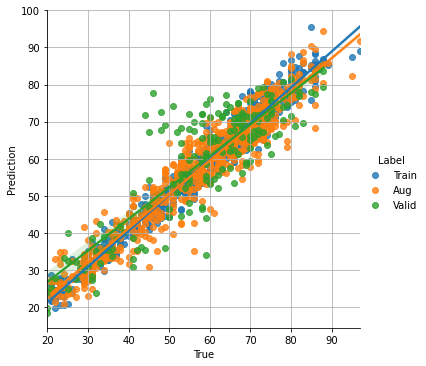

Epoch 91 / 100, BEST MAE 6.600
[train] 49.6 sec [train] 372.2 sec [eval] 12.2 sec  [TRAIN]:: Loss=8.932 Mae=2.365 Rmse=2.697 Corr=0.984 
[AUGME]:: Loss=23.770 Mae=3.815 Rmse=4.699 
[VALID]:: Loss=164.708 Mae=10.113 Rmse=12.680 Corr=0.752 
Epoch 92 / 100, BEST MAE 6.600
[train] 49.8 sec [train] 389.9 sec [eval] 12.2 sec  [TRAIN]:: Loss=8.761 Mae=2.354 Rmse=2.690 Corr=0.984 
[AUGME]:: Loss=20.528 Mae=3.526 Rmse=4.376 
[VALID]:: Loss=390.476 Mae=16.023 Rmse=19.593 Corr=0.417 
Epoch 93 / 100, BEST MAE 6.600
[train] 49.8 sec [train] 353.4 sec [eval] 12.1 sec  [TRAIN]:: Loss=8.903 Mae=2.374 Rmse=2.727 Corr=0.984 
[AUGME]:: Loss=22.302 Mae=3.607 Rmse=4.548 
[VALID]:: Loss=463.935 Mae=17.431 Rmse=21.366 Corr=0.557 
Epoch 94 / 100, BEST MAE 6.600
[train] 49.6 sec [train] 405.1 sec [eval] 12.4 sec  [TRAIN]:: Loss=8.168 Mae=2.258 Rmse=2.576 Corr=0.985 
[AUGME]:: Loss=20.511 Mae=3.434 Rmse=4.330 
[VALID]:: Loss=106.444 Mae=8.202 Rmse=10.208 Corr=0.823 
Epoch 95 / 100, BEST MAE 6.600
[train] 49.8 s

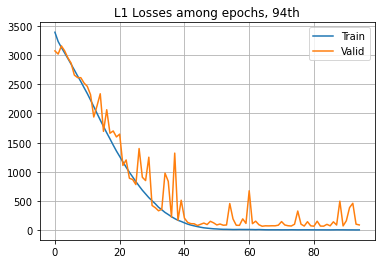

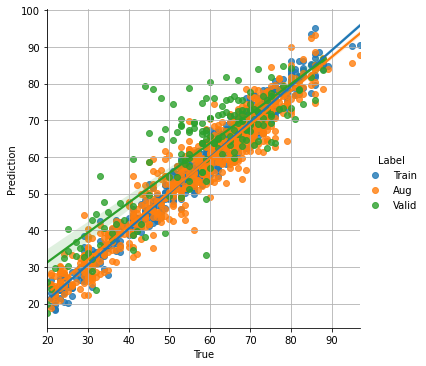

Epoch 96 / 100, BEST MAE 6.600
[train] 49.6 sec [train] 333.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=8.353 Mae=2.309 Rmse=2.602 Corr=0.985 
[AUGME]:: Loss=21.007 Mae=3.435 Rmse=4.386 
[VALID]:: Loss=208.697 Mae=11.576 Rmse=14.353 Corr=0.799 
Epoch 97 / 100, BEST MAE 6.600
[train] 49.6 sec [train] 397.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=7.821 Mae=2.191 Rmse=2.500 Corr=0.986 
[AUGME]:: Loss=20.441 Mae=3.496 Rmse=4.373 
[VALID]:: Loss=164.165 Mae=10.212 Rmse=12.674 Corr=0.812 
Epoch 98 / 100, BEST MAE 6.600
[train] 49.7 sec [train] 362.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=7.942 Mae=2.191 Rmse=2.527 Corr=0.986 
[AUGME]:: Loss=23.068 Mae=3.690 Rmse=4.627 
[VALID]:: Loss=104.510 Mae=8.135 Rmse=10.107 Corr=0.817 
Epoch 99 / 100, BEST MAE 6.600
[train] 50.2 sec [train] 355.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=8.671 Mae=2.332 Rmse=2.699 Corr=0.984 
[AUGME]:: Loss=22.147 Mae=3.555 Rmse=4.539 
[VALID]:: Loss=71.533 Mae=6.706 Rmse=8.370 Corr=0.851 
Epoch 100 / 100, BEST MAE 6.600
[train] 49.7 sec

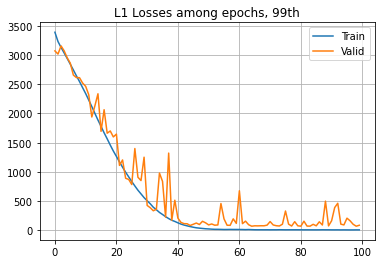

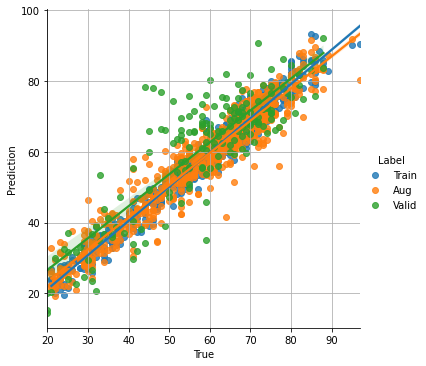

[eval] 8.3 sec  [HOLDOUT TEST]:: Loss=87.531 Mae=7.090 Rmse=9.230 Corr=0.856 


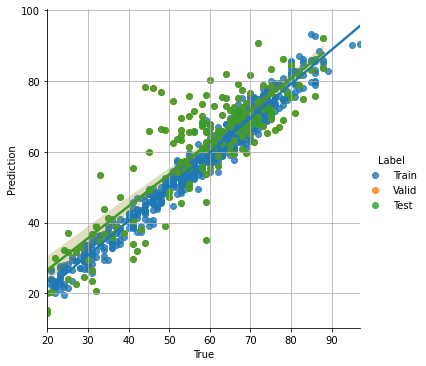

Fold 3 / 5
Model Resnet is selected.
Epoch 1 / 100, BEST MAE 10.000
[train] 50.0 sec [train] 385.0 sec [eval] 12.6 sec  [TRAIN]:: Loss=3492.732 Mae=56.810 Rmse=59.041 Corr=0.485 
[AUGME]:: Loss=3390.613 Mae=56.115 Rmse=58.168 
[VALID]:: Loss=3146.145 Mae=53.868 Rmse=55.983 Corr=0.504 
Epoch 2 / 100, BEST MAE 10.000
[train] 49.9 sec [train] 372.6 sec [eval] 12.2 sec  [TRAIN]:: Loss=3323.720 Mae=55.565 Rmse=57.589 Corr=0.738 
[AUGME]:: Loss=3275.438 Mae=55.154 Rmse=57.168 
[VALID]:: Loss=3190.607 Mae=54.465 Rmse=56.386 Corr=0.733 
Epoch 3 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 389.1 sec [eval] 12.3 sec  [TRAIN]:: Loss=3224.834 Mae=54.719 Rmse=56.724 Corr=0.777 
[AUGME]:: Loss=3180.272 Mae=54.326 Rmse=56.329 
[VALID]:: Loss=3202.894 Mae=54.699 Rmse=56.501 Corr=0.757 
Epoch 4 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 391.1 sec [eval] 13.4 sec  [TRAIN]:: Loss=3132.903 Mae=53.908 Rmse=55.907 Corr=0.787 
[AUGME]:: Loss=3089.119 Mae=53.511 Rmse=55.514 
[VALID]:: Loss=2892.772 Ma

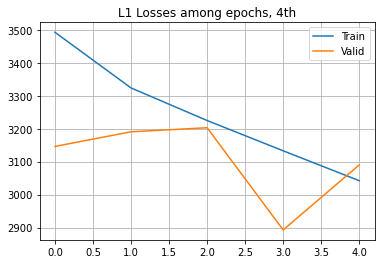

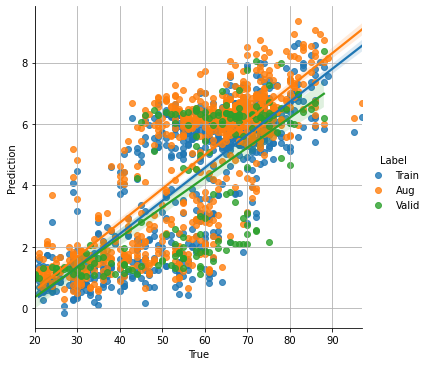

Epoch 6 / 100, BEST MAE 10.000
[train] 50.2 sec [train] 350.7 sec [eval] 12.2 sec  [TRAIN]:: Loss=2950.078 Mae=52.253 Rmse=54.247 Corr=0.797 
[AUGME]:: Loss=2905.564 Mae=51.833 Rmse=53.835 
[VALID]:: Loss=2978.472 Mae=52.589 Rmse=54.477 Corr=0.662 
Epoch 7 / 100, BEST MAE 10.000
[train] 50.0 sec [train] 364.6 sec [eval] 12.8 sec  [TRAIN]:: Loss=2858.011 Mae=51.406 Rmse=53.392 Corr=0.805 
[AUGME]:: Loss=2812.518 Mae=50.976 Rmse=52.964 
[VALID]:: Loss=2981.561 Mae=52.497 Rmse=54.501 Corr=0.524 
Epoch 8 / 100, BEST MAE 10.000
[train] 51.4 sec [train] 351.7 sec [eval] 12.1 sec  [TRAIN]:: Loss=2761.124 Mae=50.508 Rmse=52.477 Corr=0.815 
[AUGME]:: Loss=2715.964 Mae=50.061 Rmse=52.044 
[VALID]:: Loss=2596.728 Mae=48.857 Rmse=50.852 Corr=0.752 
Epoch 9 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 347.8 sec [eval] 12.2 sec  [TRAIN]:: Loss=2659.216 Mae=49.550 Rmse=51.496 Corr=0.823 
[AUGME]:: Loss=2611.758 Mae=49.080 Rmse=51.033 
[VALID]:: Loss=2651.564 Mae=49.494 Rmse=51.396 Corr=0.718 
Epoc

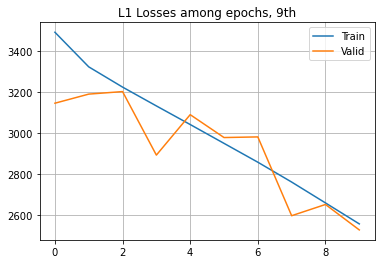

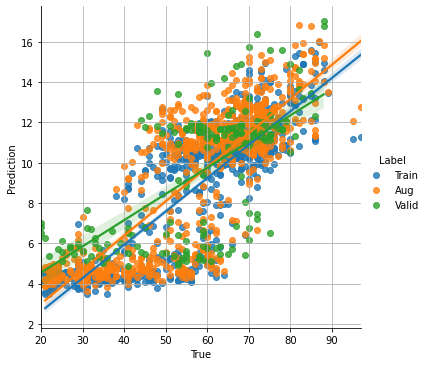

Epoch 11 / 100, BEST MAE 10.000
[train] 50.3 sec [train] 376.1 sec [eval] 12.2 sec  [TRAIN]:: Loss=2444.525 Mae=47.497 Rmse=49.367 Corr=0.840 
[AUGME]:: Loss=2392.953 Mae=46.964 Rmse=48.842 
[VALID]:: Loss=2585.394 Mae=48.544 Rmse=50.737 Corr=0.412 
Epoch 12 / 100, BEST MAE 10.000
[train] 51.1 sec [train] 370.5 sec [eval] 13.3 sec  [TRAIN]:: Loss=2329.782 Mae=46.382 Rmse=48.191 Corr=0.857 
[AUGME]:: Loss=2278.576 Mae=45.815 Rmse=47.657 
[VALID]:: Loss=2461.277 Mae=47.307 Rmse=49.500 Corr=0.458 
Epoch 13 / 100, BEST MAE 10.000
[train] 55.8 sec [train] 361.3 sec [eval] 12.9 sec  [TRAIN]:: Loss=2211.277 Mae=45.218 Rmse=46.945 Corr=0.877 
[AUGME]:: Loss=2159.210 Mae=44.624 Rmse=46.387 
[VALID]:: Loss=2300.003 Mae=45.845 Rmse=47.851 Corr=0.594 
Epoch 14 / 100, BEST MAE 10.000
[train] 51.8 sec [train] 338.7 sec [eval] 12.2 sec  [TRAIN]:: Loss=2092.235 Mae=44.019 Rmse=45.659 Corr=0.893 
[AUGME]:: Loss=2045.505 Mae=43.427 Rmse=45.144 
[VALID]:: Loss=2332.782 Mae=45.899 Rmse=48.183 Corr=0.389 


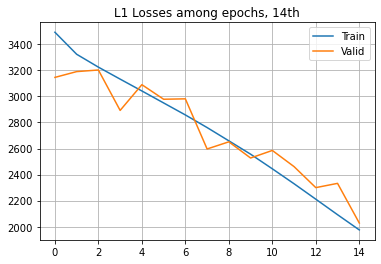

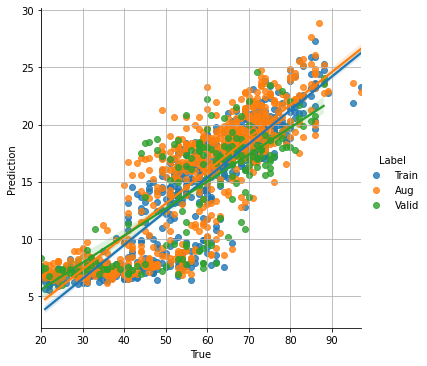

Epoch 16 / 100, BEST MAE 10.000
[train] 52.9 sec [train] 402.0 sec [eval] 12.6 sec  [TRAIN]:: Loss=1863.158 Mae=41.603 Rmse=43.077 Corr=0.910 
[AUGME]:: Loss=1813.219 Mae=40.925 Rmse=42.493 
[VALID]:: Loss=1614.798 Mae=37.685 Rmse=40.070 Corr=0.682 
Epoch 17 / 100, BEST MAE 10.000
[train] 50.6 sec [train] 408.4 sec [eval] 12.3 sec  [TRAIN]:: Loss=1743.887 Mae=40.283 Rmse=41.669 Corr=0.922 
[AUGME]:: Loss=1697.677 Mae=39.600 Rmse=41.112 
[VALID]:: Loss=1494.402 Mae=36.466 Rmse=38.547 Corr=0.764 
Epoch 18 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 386.1 sec [eval] 12.3 sec  [TRAIN]:: Loss=1628.862 Mae=38.956 Rmse=40.265 Corr=0.930 
[AUGME]:: Loss=1589.463 Mae=38.284 Rmse=39.772 
[VALID]:: Loss=1309.391 Mae=33.040 Rmse=36.055 Corr=0.489 
Epoch 19 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 364.8 sec [eval] 12.7 sec  [TRAIN]:: Loss=1518.687 Mae=37.615 Rmse=38.871 Corr=0.933 
[AUGME]:: Loss=1483.966 Mae=36.999 Rmse=38.424 
[VALID]:: Loss=1265.746 Mae=33.335 Rmse=35.460 Corr=0.758 


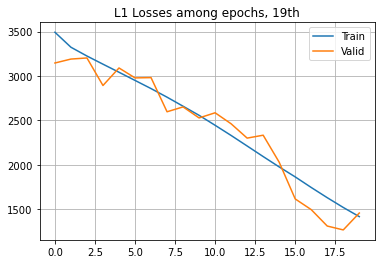

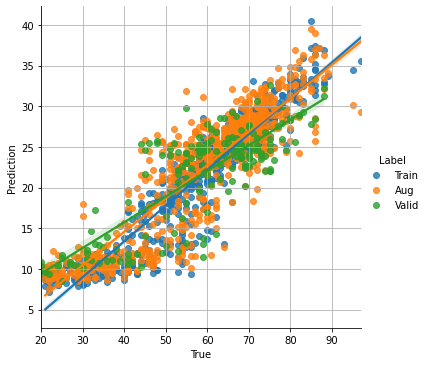

Epoch 21 / 100, BEST MAE 10.000
[train] 51.4 sec [train] 344.7 sec [eval] 12.8 sec  [TRAIN]:: Loss=1311.938 Mae=34.994 Rmse=36.113 Corr=0.945 
[AUGME]:: Loss=1282.251 Mae=34.370 Rmse=35.701 
[VALID]:: Loss=1052.195 Mae=29.530 Rmse=32.308 Corr=0.676 
Epoch 22 / 100, BEST MAE 10.000
[train] 53.0 sec [train] 393.7 sec [eval] 12.6 sec  [TRAIN]:: Loss=1213.150 Mae=33.687 Rmse=34.719 Corr=0.951 
[AUGME]:: Loss=1187.981 Mae=33.061 Rmse=34.354 
[VALID]:: Loss=1307.676 Mae=34.380 Rmse=36.064 Corr=0.797 
Epoch 23 / 100, BEST MAE 10.000
[train] 52.8 sec [train] 389.5 sec [eval] 12.4 sec  [TRAIN]:: Loss=1126.926 Mae=32.472 Rmse=33.452 Corr=0.954 
[AUGME]:: Loss=1099.189 Mae=31.782 Rmse=33.037 
[VALID]:: Loss=1047.580 Mae=29.685 Rmse=32.244 Corr=0.737 
Epoch 24 / 100, BEST MAE 10.000
[train] 51.4 sec [train] 369.1 sec [eval] 12.5 sec  [TRAIN]:: Loss=1035.174 Mae=31.130 Rmse=32.051 Corr=0.956 
[AUGME]:: Loss=1011.293 Mae=30.474 Rmse=31.679 
[VALID]:: Loss=932.548 Mae=28.366 Rmse=30.436 Corr=0.790 
E

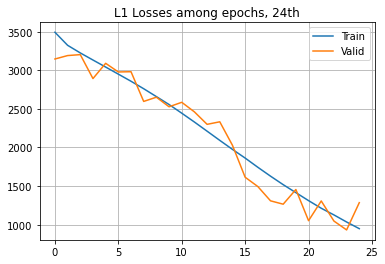

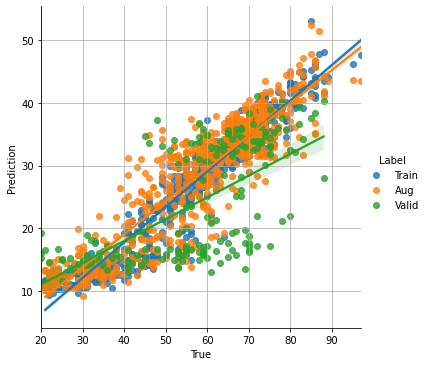

Epoch 26 / 100, BEST MAE 10.000
[train] 53.5 sec [train] 410.3 sec [eval] 12.7 sec  [TRAIN]:: Loss=874.093 Mae=28.597 Rmse=29.434 Corr=0.960 
[AUGME]:: Loss=853.419 Mae=27.911 Rmse=29.077 
[VALID]:: Loss=614.781 Mae=21.976 Rmse=24.671 Corr=0.767 
Epoch 27 / 100, BEST MAE 10.000
[train] 52.2 sec [train] 375.7 sec [eval] 12.3 sec  [TRAIN]:: Loss=792.354 Mae=27.247 Rmse=28.009 Corr=0.965 
[AUGME]:: Loss=776.808 Mae=26.622 Rmse=27.729 
[VALID]:: Loss=1048.881 Mae=30.231 Rmse=32.287 Corr=0.708 
Epoch 28 / 100, BEST MAE 10.000
[train] 52.4 sec [train] 373.4 sec [eval] 12.7 sec  [TRAIN]:: Loss=719.255 Mae=25.945 Rmse=26.672 Corr=0.965 
[AUGME]:: Loss=706.632 Mae=25.331 Rmse=26.440 
[VALID]:: Loss=602.127 Mae=21.794 Rmse=24.411 Corr=0.785 
Epoch 29 / 100, BEST MAE 10.000
[train] 52.5 sec [train] 362.6 sec [eval] 12.1 sec  [TRAIN]:: Loss=652.880 Mae=24.720 Rmse=25.397 Corr=0.966 
[AUGME]:: Loss=640.675 Mae=24.086 Rmse=25.165 
[VALID]:: Loss=1083.586 Mae=30.248 Rmse=32.789 Corr=0.584 
Epoch 30 /

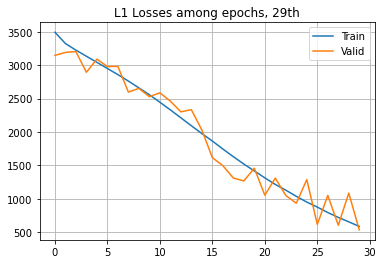

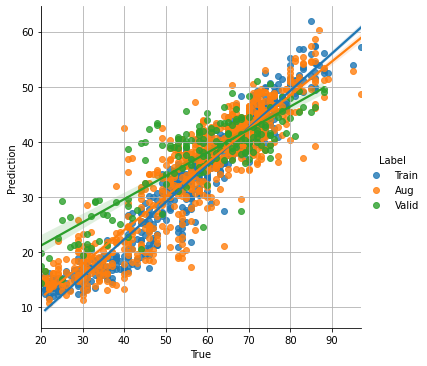

Epoch 31 / 100, BEST MAE 10.000
[train] 51.8 sec [train] 399.3 sec [eval] 12.4 sec  [TRAIN]:: Loss=529.287 Mae=22.201 Rmse=22.833 Corr=0.966 
[AUGME]:: Loss=524.040 Mae=21.542 Rmse=22.718 
[VALID]:: Loss=496.637 Mae=19.920 Rmse=22.176 Corr=0.833 
Epoch 32 / 100, BEST MAE 10.000
[train] 51.7 sec [train] 401.8 sec [eval] 12.8 sec  [TRAIN]:: Loss=472.968 Mae=20.933 Rmse=21.565 Corr=0.964 
[AUGME]:: Loss=467.582 Mae=20.372 Rmse=21.444 
[VALID]:: Loss=582.252 Mae=22.154 Rmse=24.043 Corr=0.805 
Epoch 33 / 100, BEST MAE 10.000
[train] 53.1 sec [train] 365.9 sec [eval] 12.5 sec  [TRAIN]:: Loss=415.849 Mae=19.687 Rmse=20.199 Corr=0.972 
[AUGME]:: Loss=412.237 Mae=19.085 Rmse=20.117 
[VALID]:: Loss=274.669 Mae=14.022 Rmse=16.440 Corr=0.819 
Epoch 34 / 100, BEST MAE 10.000
[train] 54.7 sec [train] 368.5 sec [eval] 12.2 sec  [TRAIN]:: Loss=368.965 Mae=18.522 Rmse=19.002 Corr=0.973 
[AUGME]:: Loss=369.016 Mae=17.942 Rmse=19.015 
[VALID]:: Loss=642.144 Mae=22.857 Rmse=25.213 Corr=0.728 
Epoch 35 / 1

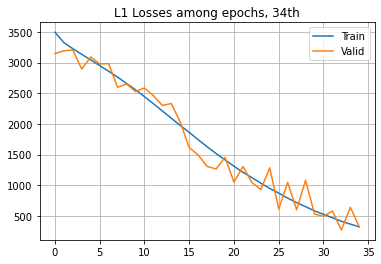

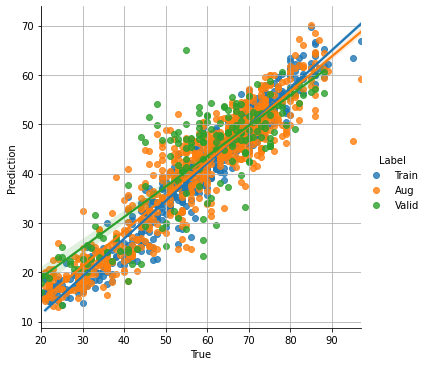

Epoch 36 / 100, BEST MAE 10.000
[train] 52.6 sec [train] 387.6 sec [eval] 12.8 sec  [TRAIN]:: Loss=282.970 Mae=16.145 Rmse=16.587 Corr=0.974 
[AUGME]:: Loss=285.211 Mae=15.685 Rmse=16.676 
[VALID]:: Loss=376.178 Mae=17.469 Rmse=19.299 Corr=0.833 
Epoch 37 / 100, BEST MAE 10.000
[train] 52.3 sec [train] 398.6 sec [eval] 12.7 sec  [TRAIN]:: Loss=247.656 Mae=15.102 Rmse=15.485 Corr=0.977 
[AUGME]:: Loss=259.160 Mae=14.735 Rmse=15.865 
[VALID]:: Loss=356.162 Mae=16.643 Rmse=18.769 Corr=0.808 
Epoch 38 / 100, BEST MAE 10.000
[train] 51.4 sec [train] 375.8 sec [eval] 13.4 sec  [TRAIN]:: Loss=217.869 Mae=14.117 Rmse=14.493 Corr=0.977 
[AUGME]:: Loss=225.905 Mae=13.675 Rmse=14.793 
[VALID]:: Loss=250.214 Mae=13.594 Rmse=15.702 Corr=0.818 
Epoch 39 / 100, BEST MAE 10.000
[train] 56.4 sec [train] 410.2 sec [eval] 12.9 sec  [TRAIN]:: Loss=187.436 Mae=12.994 Rmse=13.397 Corr=0.975 
[AUGME]:: Loss=197.929 Mae=12.633 Rmse=13.806 
[VALID]:: Loss=211.528 Mae=12.193 Rmse=14.463 Corr=0.634 
Epoch 40 / 1

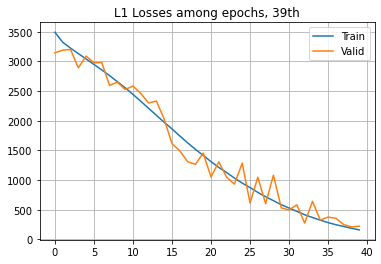

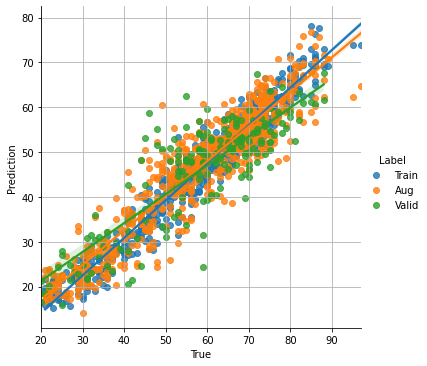

Epoch 41 / 100, BEST MAE 10.000
[train] 52.2 sec [train] 368.0 sec [eval] 12.6 sec  Saving ...
[TRAIN]:: Loss=133.268 Mae=10.839 Rmse=11.194 Corr=0.977 
[AUGME]:: Loss=149.352 Mae=10.817 Rmse=11.931 
[VALID]:: Loss=127.048 Mae=9.352 Rmse=11.151 Corr=0.803 
Epoch 42 / 100, BEST MAE 9.352
[train] 50.6 sec [train] 390.1 sec [eval] 12.4 sec  [TRAIN]:: Loss=112.076 Mae=9.895 Rmse=10.210 Corr=0.979 
[AUGME]:: Loss=130.011 Mae=9.953 Rmse=11.113 
[VALID]:: Loss=195.121 Mae=11.808 Rmse=13.834 Corr=0.837 
Epoch 43 / 100, BEST MAE 9.352
[train] 50.7 sec [train] 382.9 sec [eval] 12.9 sec  Saving ...
[TRAIN]:: Loss=98.175 Mae=9.172 Rmse=9.515 Corr=0.978 
[AUGME]:: Loss=110.615 Mae=9.191 Rmse=10.219 
[VALID]:: Loss=99.057 Mae=8.052 Rmse=9.825 Corr=0.827 
Epoch 44 / 100, BEST MAE 8.052
[train] 53.3 sec [train] 352.4 sec [eval] 12.4 sec  [TRAIN]:: Loss=82.160 Mae=8.332 Rmse=8.634 Corr=0.980 
[AUGME]:: Loss=99.836 Mae=8.573 Rmse=9.679 
[VALID]:: Loss=117.480 Mae=8.813 Rmse=10.732 Corr=0.840 
Epoch 45 /

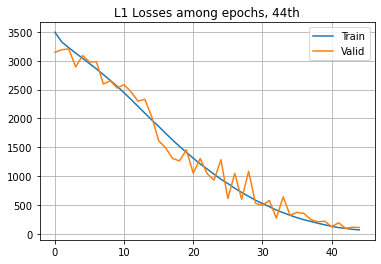

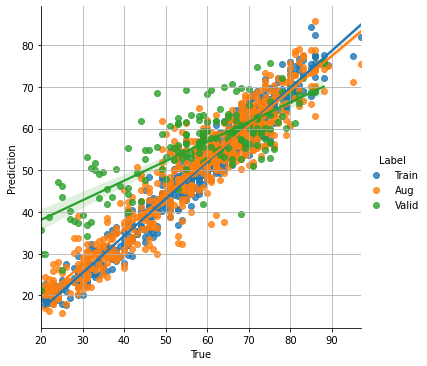

Epoch 46 / 100, BEST MAE 8.052
[train] 51.0 sec [train] 372.3 sec [eval] 12.8 sec  [TRAIN]:: Loss=56.484 Mae=6.739 Rmse=7.010 Corr=0.981 
[AUGME]:: Loss=74.930 Mae=7.170 Rmse=8.269 
[VALID]:: Loss=102.921 Mae=8.336 Rmse=10.065 Corr=0.849 
Epoch 47 / 100, BEST MAE 8.052
[train] 50.8 sec [train] 367.5 sec [eval] 12.7 sec  [TRAIN]:: Loss=48.049 Mae=6.114 Rmse=6.425 Corr=0.980 
[AUGME]:: Loss=67.280 Mae=6.789 Rmse=7.861 
[VALID]:: Loss=96.624 Mae=8.307 Rmse=9.723 Corr=0.832 
Epoch 48 / 100, BEST MAE 8.052
[train] 52.0 sec [train] 374.0 sec [eval] 12.9 sec  [TRAIN]:: Loss=41.572 Mae=5.581 Rmse=5.952 Corr=0.977 
[AUGME]:: Loss=58.827 Mae=6.212 Rmse=7.337 
[VALID]:: Loss=124.022 Mae=9.007 Rmse=11.021 Corr=0.804 
Epoch 49 / 100, BEST MAE 8.052
[train] 51.0 sec [train] 367.7 sec [eval] 12.6 sec  Saving ...
[TRAIN]:: Loss=33.304 Mae=4.912 Rmse=5.281 Corr=0.979 
[AUGME]:: Loss=51.200 Mae=5.810 Rmse=6.889 
[VALID]:: Loss=91.941 Mae=7.900 Rmse=9.452 Corr=0.823 
Epoch 50 / 100, BEST MAE 7.900
[train

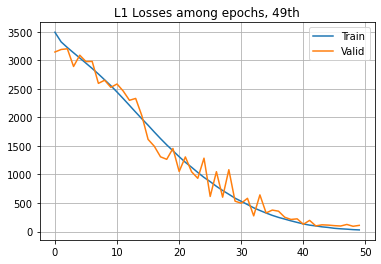

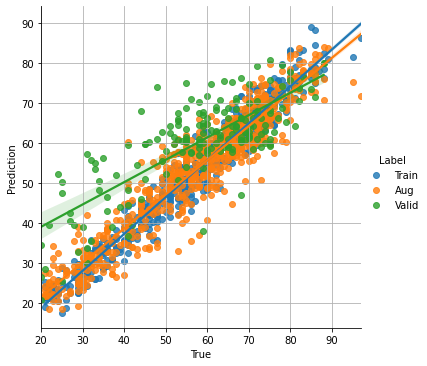

Epoch 51 / 100, BEST MAE 7.900
[train] 52.6 sec [train] 338.4 sec [eval] 13.0 sec  [TRAIN]:: Loss=23.845 Mae=4.013 Rmse=4.367 Corr=0.980 
[AUGME]:: Loss=42.178 Mae=5.164 Rmse=6.267 
[VALID]:: Loss=142.209 Mae=9.590 Rmse=11.781 Corr=0.796 
Epoch 52 / 100, BEST MAE 7.900
[train] 50.6 sec [train] 365.9 sec [eval] 12.2 sec  [TRAIN]:: Loss=20.435 Mae=3.681 Rmse=4.046 Corr=0.980 
[AUGME]:: Loss=39.209 Mae=4.911 Rmse=6.006 
[VALID]:: Loss=104.869 Mae=8.273 Rmse=10.158 Corr=0.820 
Epoch 53 / 100, BEST MAE 7.900
[train] 49.6 sec [train] 342.7 sec [eval] 12.1 sec  [TRAIN]:: Loss=18.769 Mae=3.476 Rmse=3.871 Corr=0.979 
[AUGME]:: Loss=37.716 Mae=4.798 Rmse=5.870 
[VALID]:: Loss=125.048 Mae=9.021 Rmse=11.033 Corr=0.802 
Epoch 54 / 100, BEST MAE 7.900
[train] 49.4 sec [train] 330.6 sec [eval] 12.4 sec  [TRAIN]:: Loss=17.163 Mae=3.351 Rmse=3.741 Corr=0.979 
[AUGME]:: Loss=36.467 Mae=4.638 Rmse=5.816 
[VALID]:: Loss=142.107 Mae=9.675 Rmse=11.731 Corr=0.745 
Epoch 55 / 100, BEST MAE 7.900
[train] 49.5 

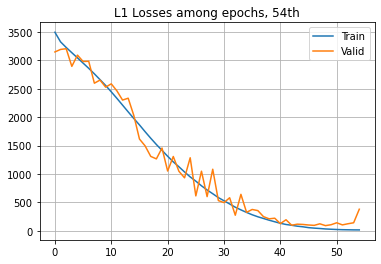

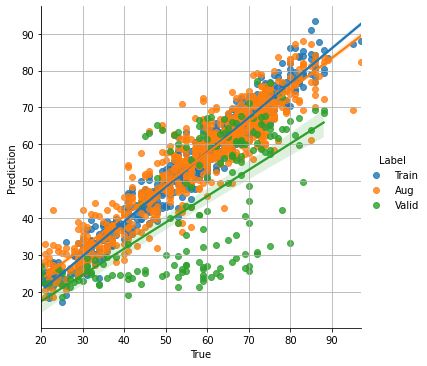

Epoch 56 / 100, BEST MAE 7.900
[train] 49.4 sec 

FileNotFoundError: [Errno 2] No such file or directory: '../../brainmask_tlrc\\reconV6_OAS1_0157_MR1-brainmask_tlrc.npy'

In [4]:
for fold in range(cfg.folds):
    
    print(f'Fold {fold+1} / {cfg.folds}')
    model, dps, res = run(cfg, fold)
    models.append(model)
    packets.append(dps)
    
    cfg.test = True
    model, tst_dp, tst_res = eval(model, fn_lst, tst_dp, cfg, fold=None)
    
    df = pd.concat([make_df(res[0], 'Train'),
                   make_df(res[1], 'Valid'),
                   make_df(tst_res, 'Test')], ignore_index=True)
    
    tst_dp.corr.update(df[df['Label'] == 'Test'].corr().Prediction['True'])
    tst_dp.refresh()
    
    # Show Holdout testset information
    tst_dp.info('Holdout test')
    sns.lmplot(data=df, x='True', y='Prediction', hue='Label')
    plt.grid()
    plt.show()
    
    torch.cuda.empty_cache()

## Ensemble

### Naive Averaging

In [39]:
# Ensemble
preds = dict()
models = glob('./models/ensembles/*.pth')
for fold, state in enumerate(models):
    
    model, device = load_model('resnet', verbose=False)
    model = torch.load(state)
    
    model, (_, _, _), tst_preds = eval(model, True, None, None, resize, device, batch_size,
                                      loss_fn, mae_fn, rmse_fn,
                                      [], [], [])
    
    preds[f'model_{fold}'] = list(map(float, tst_preds[1]))
    
ensemble_results = pd.DataFrame(preds)
ensemble_results['Avg'] = ensemble_results.mean(axis=1)
ensemble_results['True'] = list(map(float, tst_preds[0]))

Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.


In [64]:
def result_plot(df):
    
    avg = torch.Tensor(ensemble_results['Avg'])
    tru = torch.Tensor(ensemble_results['True'])
    
    corr = ensemble_results.corr()['True']['Avg']
    mae_fn, rmse_fn = nn.L1Loss(), RMSELoss()
    
    print(f'Ensemble Results')
    print(f'MAE  = {float(mae_fn(avg, tru)):.3f}')
    print(f'RMSE = {float(rmse_fn(avg, tru)):.3f}')
    print(f'CORR = {corr:.3f}')
    
    sns.lmplot(data=ensemble_results, x='True', y='Avg')
    plt.grid()
    plt.show()

Ensemble Results
MAE  = 7.025
RMSE = 8.598
CORR = 0.854


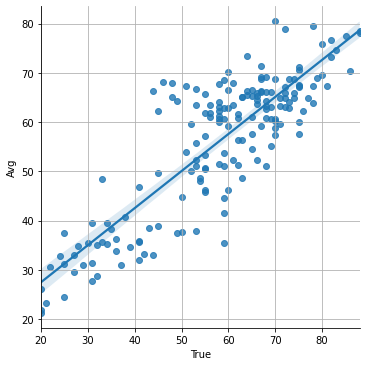

In [65]:
result_plot(ensemble_results)

### Blender

In [7]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [8]:
class CFG:
    
    model_name='resnet'
    dropout=0.1
    use_last_layer=True

In [10]:
class Ensemble(nn.Module):
    
    def __init__(self, model_list, CFG):
        super(Ensemble, self).__init__()
        
        self.cfg = CFG
        self.dropout = self.cfg.dropout
        self.models = dict()
        
        for idx, model_path in enumerate(model_list):
            
            model, device = load_model(self.cfg.model_name, verbose=False)
            model = torch.load(model_path)
            if not self.cfg.use_last_layer:
                model.fc = Identity()
                
                self.last_layer = nn.Sequential(
                    nn.Linear(len(model_list) * 128, 128),
                    nn.Dropout(self.dropout),
                    nn.Linear(128, 1)
#                     nn.Dropout(self.dropout)
                )
                
            else:
                self.last_layer = nn.Sequential(
                    nn.Linear(len(model_list), 1),
#                     nn.Dropout(self.dropout)
                )
                
            for param in model.parameters():
                param.requires_grad = False
                
            self.models[idx] = model
        
    def forward(self, x):
        
        vectors = list()
        for idx, model in self.models.items():
            vectors.append(model(x))
            
        x = torch.cat(vectors, dim=1)
        x = self.last_layer(x)
        
        return x

In [11]:
model_list = glob('./models/ensembles/rough/*.pth')
model_list.sort()
cfg = CFG()
cfg.use_last_layer = True
model = Ensemble(model_list, cfg).to(device)
with torch.no_grad():
    model.last_layer[0].weight.fill_(1 / len(model_list))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
